<p style="font-size:36px;text-align:center"> <b>Personalized cancer diagnosis</b> </p>

<h2>Import necessary libraries

In [1]:
#Import necessary libraries
import pandas as pd
from prettytable import PrettyTable
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from string import punctuation
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
import squarify
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

pd.set_option('display.max_colwidth', -1) 

C:\Users\Vibhuti\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


<h2>All utility functions, which are used across this notebook

In [375]:
#Get information of a data
def getDataInsights(data):
    #1. Total no of data points
    print('\x1b[1;03;55;55m')
    print("Total no of data points=", data.shape[0] ,"and feature =", data.shape[1])


    #2. Find feature data type 
    print("\n")
    print("Types of each feature")
    print("---------------------")
    print(data.dtypes)

    #Let  us check if there exist any missing values
    print("\n")
    print("Find null entries per feature")
    print("--------------------------------")
    print(data.isnull().sum())


    print("\n")
    print("Find unique data")
    print(data.apply(pd.Series.nunique))


    #let us have a glimpse of data 
    print(data.head())


# loading stop words from nltk library
#remove refernces of fig and table and author from text- checked text in csv
bookreferenceWords=['al et','al','et','author','fig','figure','also','table','mutations']
stop_words = set(stopwords.words('english') + list(punctuation) + bookreferenceWords)

def nlp_preprocessing(total_text, index, column,data):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        data[column][index] = string
def GetDistributioninTable(data,col_name): 
    print('\x1b[1;03;55;55m')
    print("Distribution of",col_name)

    values_count = pd.DataFrame(data[col_name].value_counts())    
    values_count.columns = ['count'] 
    values_count[col_name] = [ str(i) for i in values_count.index ]
    values_count['percent'] = values_count['count'].div(values_count['count'].sum()).multiply(100).round(2) 
    values_count = values_count.reindex_axis([col_name,'count','percent'],axis=1)
    values_count.reset_index(drop=True,inplace=True) 
    x =  PrettyTable(header_style='upper', padding_width=5)     
    for col in values_count.columns:
        x.add_column(column=values_count[col],fieldname=col)
    print(x)

def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)     
    B =(C/C.sum(axis=0)) 
    
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
#Find feature's relation with class label
def relationWithclass(X,y,cv_X,cv_y,test_X,test_y):
    alpha = [10 ** x for x in range(-5, 1)] 
    cv_log_error_array=[]
    for i in alpha:
        clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
        clf.fit(X, y)

        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(X, y)
        predict_y = sig_clf.predict_proba(cv_X)
        cv_log_error_array.append(log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15))
        print('For values of alpha = ', i, "The log loss is:",log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15))

    fig, ax = plt.subplots()
    ax.plot(alpha, cv_log_error_array,c='g')
    for i, txt in enumerate(np.round(cv_log_error_array,3)):
        ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
    plt.grid()
    plt.title("Cross Validation Error for each alpha")
    plt.xlabel("Alpha i's")
    plt.ylabel("Error measure")
    plt.show()


    best_alpha = np.argmin(cv_log_error_array)
    clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
    clf.fit(X, y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X, y)

    predict_y = sig_clf.predict_proba(X)
    print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y, predict_y, labels=clf.classes_, eps=1e-15))
    predict_y = sig_clf.predict_proba(cv_X)
    print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15))
    predict_y = sig_clf.predict_proba(test_X)
    print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15))

#Build logreg model
def buildModel(train_x,cv_x,test_x,name):
    print('\x1b[1;03;55;55m')
    modelAnalysis = {"Alpha":[], "LogLoss":[]}   
    if(name=='KNN'):
        alpha = [5, 11, 15, 21, 31, 41, 51, 99]
    else:
        alpha = [10 ** x for x in range(-6, 3)]
    cv_log_error_array = []
    for i in alpha:
        modelAnalysis["Alpha"].append(i)       
        if(name =="NB"):
            clf = MultinomialNB(alpha=i)
            clf.fit(train_x, train_y)
        if(name=="KNN"):
            clf = KNeighborsClassifier(n_neighbors=i)
            clf.fit(train_x, train_y)
        if(name=="LogRegBalance"):
            clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
            clf.fit(train_x, train_y)
        if(name=="LogReg"):
            clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
            clf.fit(train_x, train_y)
        if(name=="RF"):
            clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
            clf.fit(train_x, train_y)
        if(name=="SVM"):
            clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
            clf.fit(train_x, train_y)
             
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        # to avoid rounding error while multiplying probabilites we use log-probability estimates
        modelAnalysis["LogLoss"].append(log_loss(cv_y, sig_clf_probs)) 
    
    x =  PrettyTable(header_style='upper', padding_width=5)  
    modelAnalysis=pd.DataFrame(modelAnalysis)
    for col in modelAnalysis.columns:
        x.add_column(column=modelAnalysis[col],fieldname=col)
    print(x)   
    fig, ax = plt.subplots()
    ax.plot(alpha, cv_log_error_array,c='g')
    for i, txt in enumerate(np.round(cv_log_error_array,3)):
        ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
    plt.grid()
    plt.title("Cross Validation Error for each alpha")
    plt.xlabel("Alpha i's")
    plt.ylabel("Error measure")
    plt.show()

    print('\x1b[1;03;55;55m')
    best_alpha = np.argmin(cv_log_error_array)
    clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)

    predict_y = sig_clf.predict_proba(train_x)
    print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
    predict_y = sig_clf.predict_proba(cv_x)
    print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    predict_y = sig_clf.predict_proba(test_x)
    print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print("Best alpha for model ",name ,"is ",alpha[best_alpha])
     
    return   alpha[best_alpha]


    
def findDistribution(col_name,data):
    unique_vals = data[col_name].value_counts()
    print('Number of Unique values', unique_vals.shape[0])
    # the top 10 genes that occured most
    print(unique_vals.head(10))
    s = sum(unique_vals.values);
    h = unique_vals.values/s;
    c = np.cumsum(h) 

    fig, axs = plt.subplots(1,2,figsize=(18,6))  
    axs[0].plot(h,label='Distribution of '+col_name)
    axs[0].grid()
    axs[0].legend()
    axs[1].plot(c,label='Cumulative distribution of '+col_name) 
    axs[1].grid()
    plt.legend();
    plt.show();
    
def get_gv_fea_dict(alpha, feature, df):
    # value_count: it contains a dict like
    # print(train_df['Gene'].value_counts())
    # output:
    #        {BRCA1      174
    #         TP53       106
    #         EGFR        86
    #         BRCA2       75
    #         PTEN        69
    #         KIT         61
    #         BRAF        60
    #         ERBB2       47
    #         PDGFRA      46
    #         ...}
    # print(train_df['Variation'].value_counts())
    # output:
    # {
    # Truncating_Mutations                     63
    # Deletion                                 43
    # Amplification                            43
    # Fusions                                  22
    # Overexpression                            3
    # E17K                                      3
    # Q61L                                      3
    # S222D                                     2
    # P130S                                     2
    # ...
    # }
    value_count = train_df[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 diamensional vector
        vec = []
        for k in range(1,10):
            # print(train_df.loc[(train_df['Class']==1) & (train_df['Gene']=='BRCA1')])
            #         ID   Gene             Variation  Class  
            # 2470  2470  BRCA1                S1715C      1   
            # 2486  2486  BRCA1                S1841R      1   
            # 2614  2614  BRCA1                   M1R      1   
            # 2432  2432  BRCA1                L1657P      1   
            # 2567  2567  BRCA1                T1685A      1   
            # 2583  2583  BRCA1                E1660G      1   
            # 2634  2634  BRCA1                W1718L      1   
            # cls_cnt.shape[0] will return the number of rows

            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    # print(gv_dict)
    #     {'BRCA1': [0.20075757575757575, 0.03787878787878788, 0.068181818181818177, 0.13636363636363635, 0.25, 0.19318181818181818, 0.03787878787878788, 0.03787878787878788, 0.03787878787878788], 
    #      'TP53': [0.32142857142857145, 0.061224489795918366, 0.061224489795918366, 0.27040816326530615, 0.061224489795918366, 0.066326530612244902, 0.051020408163265307, 0.051020408163265307, 0.056122448979591837], 
    #      'EGFR': [0.056818181818181816, 0.21590909090909091, 0.0625, 0.068181818181818177, 0.068181818181818177, 0.0625, 0.34659090909090912, 0.0625, 0.056818181818181816], 
    #      'BRCA2': [0.13333333333333333, 0.060606060606060608, 0.060606060606060608, 0.078787878787878782, 0.1393939393939394, 0.34545454545454546, 0.060606060606060608, 0.060606060606060608, 0.060606060606060608], 
    #      'PTEN': [0.069182389937106917, 0.062893081761006289, 0.069182389937106917, 0.46540880503144655, 0.075471698113207544, 0.062893081761006289, 0.069182389937106917, 0.062893081761006289, 0.062893081761006289], 
    #      'KIT': [0.066225165562913912, 0.25165562913907286, 0.072847682119205295, 0.072847682119205295, 0.066225165562913912, 0.066225165562913912, 0.27152317880794702, 0.066225165562913912, 0.066225165562913912], 
    #      'BRAF': [0.066666666666666666, 0.17999999999999999, 0.073333333333333334, 0.073333333333333334, 0.093333333333333338, 0.080000000000000002, 0.29999999999999999, 0.066666666666666666, 0.066666666666666666],
    #      ...
    #     }
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = train_df[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea    

import math
#https://stackoverflow.com/a/1602964
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            print(row)
            sum_prob = 0
            for word in row['IMP_WORDS'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['IMP_WORDS'].split()))
            row_index += 1
    return text_feature_responseCoding

def get_feature_dict(feature):
    newname =feature+"Class"
    train_df[newname]=''
    test_df[newname]=''
    cv_df[newname]=''
    value_count = train_df[feature].value_counts()
    gv_dict = dict()
    for i, denominator in value_count.items(): 
     
        for k in range(1,10):
            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            vec =(cls_cnt.shape[0] )/ (denominator )
            if(np.isnan(vec)):
                vec=0.111
            train_df.loc[(train_df['Class']==k) & (train_df[feature]==i),newname] = float(vec)
            cv_df.loc[(cv_df['Class']==k) & (cv_df[feature]==i),newname] = float(vec)
            test_df.loc[(test_df['Class']==k) & (test_df[feature]==i),newname] = float(vec)
# https://gist.github.com/StevenMaude/ea46edc315b0f94d03b9
def display_scores(vectorizer, tfidf_result): 
    scores = zip(vectorizer.get_feature_names(),
                 np.asarray(tfidf_result.sum(axis=0)).ravel())
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True) 
    return sorted_scores 

def findImpWords(dataframe,textList):
    for i,w in enumerate(textList):  
        impWords=[]
        j=0     
        while j<len(words):   
#             print(j)
            if(words[j] in w):
                impWords.append(words[j])   
            j+=1
            if(len(impWords)==2000):
                break;       
        dataframe.set_value(textList.index[i],'IMP_WORDS'," ".join(impWords))  
        
def get_intersec_text(df,col):
    text_vectorizer = CountVectorizer(min_df=3)
    train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df[col])
    # getting all the feature names (words)
    train_text_features= text_vectorizer.get_feature_names()
    
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df[col])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

def testOnUnseenData(classifier,model):
    dataResult = {"Actual":[], "Predicted":[], "IsTrue": [],'Probability':[], 'Important features':[]}
    for i in range(0,665): 
        predicted_cls = classifier.predict(test_x_onehotCoding[i])
        dataResult["Actual"].append(test_y[i])
        dataResult["Predicted"].append(predicted_cls[0])
        dataResult["IsTrue"].append(predicted_cls[0] == test_y[i])
        dataResult['Probability'].append(np.round(classifier.predict_proba(test_x_onehotCoding[i]),4))
        if(model!='None'):
            indices =  np.argsort(-model.coef_)[predicted_cls-1][:,:2500] 
            indices=indices[0] 
            wordcount,words=getimportantfeatures(indices,i,2500) 
            dataResult['Important features'].append(words)
        dataResult['Important features'].append(' ')
    dataResult=pd.DataFrame(dataResult)
    x =  PrettyTable(header_style='upper', padding_width=5)     
    for col in dataResult.columns:
        x.add_column(column=dataResult[col],fieldname=col)
    print(x)   
    return pd.DataFrame(dataResult)

def testOnUnseenResponseCodedDataData(model):
    dataResult = {"Actual":[], "Predicted":[], "IsTrue": [],'Probability':[]}
    for i in range(0,665): 
        predicted_cls = model.predict(test_x_responseCoding[i])
        dataResult["Actual"].append(test_y[i])
        dataResult["Predicted"].append(predicted_cls[0])
        dataResult["IsTrue"].append(predicted_cls[0] == test_y[i])
        dataResult['Probability'].append(np.round(model.predict_proba(test_x_responseCoding[i]),4))
        
    dataResult=pd.DataFrame(dataResult)
    x =  PrettyTable(header_style='upper', padding_width=5)     
    for col in dataResult.columns:
        x.add_column(column=dataResult[col],fieldname=col)
    print(x)   
    return pd.DataFrame(dataResult)

def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)
    return sig_clf
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

def buildRF(train_x_onehotCoding,cv_x_onehotCoding,test_x_onehotCoding):
    modelAnalysis = {"n_estimatrs":[],'Depth':[], "LogLoss":[]}   
#     alpha = [100,200,500,1000,2000]
#     max_depth = [5, 10]
    alpha = [10,50,100,200,500,1000]
    max_depth = [2,3,5,10]
    cv_log_error_array = []
    for i in alpha:
        for j in max_depth:
            modelAnalysis["n_estimatrs"].append(i)
            modelAnalysis["Depth"].append(j)
            clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
            clf.fit(train_x_onehotCoding, train_y)
            sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
            sig_clf.fit(train_x_onehotCoding, train_y)
            sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
            cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
            modelAnalysis["LogLoss"].append(log_loss(cv_y, sig_clf_probs)) 

    best_alpha = np.argmin(cv_log_error_array)
    clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    modelAnalysis=pd.DataFrame(modelAnalysis)
    x =  PrettyTable(header_style='upper', padding_width=5)
    for col in modelAnalysis.columns:
        x.add_column(column=modelAnalysis[col],fieldname=col)
    print(x)   
    print('\x1b[1;03;55;55m')
    predict_y = sig_clf.predict_proba(train_x_onehotCoding)
    print('For values of best estimator = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
    predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
    print('For values of best estimator = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    predict_y = sig_clf.predict_proba(test_x_onehotCoding)
    print('For values of best estimator = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

    clf = RandomForestClassifier(n_estimators=alpha[int(bestalpha/4)], criterion='gini', max_depth=max_depth[int(bestalpha%4)], random_state=42, n_jobs=-1)
    predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)
    return clf
 
def getimportantfeatures(indices,test_point_index,n):
    no_features = n 
    gene=gene_vectorizer.get_feature_names()
    var=variation_vectorizer.get_feature_names() 
    lastword=lastWord_vectorizer.get_feature_names()
    impWord=tf_idf_vect_Imp.get_feature_names() 
    fea1_len = len(gene)
    fea2_len = len(var)
    fea3_len=1 
    fea4_len=1
    fea5_len=len(lastword)
    fea6_len=len(impWord) 
    word_present = 0
    impFeat=[]
    for i,v in enumerate(indices): 
        if (v < fea1_len):
            word = gene[v]  
            yes_no = True if word == test_df['Gene'].iloc[test_point_index] else False
            if yes_no:
                word_present += 1
                impFeat.append(word)

        elif (v < fea1_len+fea2_len):
            word = var[v-(fea1_len)]
            yes_no = True if word == test_df['Variation'].iloc[test_point_index] else False
            if yes_no:
                word_present += 1
                impFeat.append(word)

        elif (v < fea1_len+fea2_len+fea3_len):
            word = train_df['GeneClass'].tolist()[v-(fea1_len+fea2_len)]
            yes_no = True if word == test_df['GeneClass'].iloc[test_point_index] else False
            if yes_no:
                word_present += 1
                impFeat.append(word)

        elif (v < fea1_len+fea2_len+fea3_len+fea4_len):
            word = train_df['VariationClass'].tolist()[v-(fea1_len+fea2_len+fea3_len)]
            yes_no = True if word == test_df['VariationClass'].iloc[test_point_index] else False
            if yes_no:
                word_present += 1
                impFeat.append(word)

        elif (v < fea1_len+fea2_len+fea3_len+fea4_len+fea5_len):
            word = lastword[v-(fea1_len+fea2_len+fea3_len+fea4_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                impFeat.append(word)

        else:
            text=test_df['IMP_WORDS'].iloc[test_point_index]
            word = impWord[v-(fea1_len+fea2_len+fea3_len+fea4_len+fea5_len+fea6_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                impFeat.append(word)
   

    return word_present,impFeat[0:20]

<h2>Read the data
<h4>Read gene variation data

In [12]:
#Read the gene data
data_Gene = pd.read_csv('training/training_variants') 
getDataInsights(data_Gene)


Total no of data points= 3321 and feature = 4


Types of each feature
---------------------
ID            int64
Gene         object
Variation    object
Class         int64
dtype: object


Find null entries per feature
--------------------------------
ID           0
Gene         0
Variation    0
Class        0
dtype: int64


Find unique data
ID           3321
Gene          264
Variation    2996
Class           9
dtype: int64
   ID    Gene             Variation  Class
0   0  FAM58A  Truncating Mutations      1
1   1     CBL                 W802*      2
2   2     CBL                 Q249E      2
3   3     CBL                 N454D      3
4   4     CBL                 L399V      4


<b> Observations from above exploration
<ul>
<li> It is a small dataset with total rows= 3321
<li> ID is an integer unique key for each row
<li> We have total 264 unique Gene values in dataset
<li> We do not have any null values in our dataset 
<li> Our label "Class"- is an integer variable with total 9 values possible. (from 1 to 9)
</ul>

<h4>Read the text data

In [7]:
#Let us merge the text dataset with gene and variation data
# note the seprator in this file
data_text =pd.read_csv("training/training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
getDataInsights(data_text)


Total no of data points= 3321 and feature = 2


Types of each feature
---------------------
ID       int64
TEXT    object
dtype: object


Find null entries per feature
--------------------------------
ID      0
TEXT    0
dtype: int64


Find unique data
ID      3321
TEXT    1921
dtype: int64
   ID                                               TEXT
0   0  Cyclin-dependent kinases (CDKs) regulate a var...
1   1   Abstract Background  Non-small cell lung canc...
2   2   Abstract Background  Non-small cell lung canc...
3   3  Recent evidence has demonstrated that acquired...
4   4  Oncogenic mutations in the monomeric Casitas B...


<b>Observations from above exploration
<ul>
<li> The text and Gene data are connected by the unique key ID, we will merge this two datasets.
<li> We have total 1921 unique text entries in 3321 datapoints
<li> This shows that text data is duplicated for some gene and variation combination.
</ul>

<h2> Preprocessing for Text Data, Remove book reference words punctuations from the text

In [3]:
 
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT',data_text)
    else:
        print("there is no text description for id:",index)


<h4>Merge text data with gene and variation data

In [13]:
#merging both gene_variations and text data based on ID
result = pd.merge(data_Gene, data_text,on='ID', how='left')
getDataInsights(result)


Total no of data points= 3321 and feature = 5


Types of each feature
---------------------
ID            int64
Gene         object
Variation    object
Class         int64
TEXT         object
dtype: object


Find null entries per feature
--------------------------------
ID           0
Gene         0
Variation    0
Class        0
TEXT         0
dtype: int64


Find unique data
ID           3321
Gene          264
Variation    2996
Class           9
TEXT         1921
dtype: int64
   ID    Gene             Variation  Class  \
0   0  FAM58A  Truncating Mutations      1   
1   1     CBL                 W802*      2   
2   2     CBL                 Q249E      2   
3   3     CBL                 N454D      3   
4   4     CBL                 L399V      4   

                                                TEXT  
0  cyclin dependent kinases cdks regulate variety...  
1  abstract background non small cell lung cancer...  
2  abstract background non small cell lung cancer...  
3  recent evidence de

<b>Check for duplictae text data and find its effects 

In [9]:
print("Total duplicate text",sum(result.duplicated('TEXT'))) 
data_duplicate = train_df.loc[result.duplicated('TEXT'),:]
Ids=data_duplicate['ID']
data_duplicate.head()

Total duplicate text 1400


,ID,Gene,Variation,Class,TEXT,GeneClass,IMP_WORDS,VariationClass
2040,2040,MAP2K2,S222D,6,abstract cardio facio cutaneous cfc syndrome s...,0.333333,cells cell mutation cancer patients protein ac...,0.119565
1363,1363,AKT1,N53A,7,protein kinase v akt murine thymoma viral onco...,0.642857,cells cell mutation pten cancer patients prote...,0.120879
1762,1762,IDH1,I99M,5,introduction somatic mutations human cytosolic...,0.461538,cells variants cell mutation cancer patients p...,0.120879
2673,2673,BRCA1,S1473P,5,abstract germline inactivating mutations brca1...,0.317365,brca1 cells variants cell mutation cancer pati...,0.120879
920,920,PDGFRA,C456_R481del,7,introduction pediatric high grade gliomas hgg ...,0.743590,cells cell mutation cancer egfr patients p53 p...,0.120879


In [10]:
for i,index in enumerate(Ids):  
    T=train_df.loc[index,'TEXT'] 
    print(train_df.loc[train_df.TEXT==T,['Gene','Variation','Class','TEXT']]) 


        Gene Variation  Class  \
2040  MAP2K2     S222D      6   
2039  MAP2K2      F57C      7   

                                                   TEXT  
2040  abstract cardio facio cutaneous cfc syndrome s...  
2039  abstract cardio facio cutaneous cfc syndrome s...  
      Gene Variation  Class                                               TEXT
1363  AKT1      N53A      7  protein kinase v akt murine thymoma viral onco...
1355  AKT1     V271A      7  protein kinase v akt murine thymoma viral onco...
1351  AKT1      Q79E      7  protein kinase v akt murine thymoma viral onco...
1365  AKT1      R23A      7  protein kinase v akt murine thymoma viral onco...
1345  AKT1     L362R      3  protein kinase v akt murine thymoma viral onco...
1346  AKT1     V270A      7  protein kinase v akt murine thymoma viral onco...
1362  AKT1     K189N      7  protein kinase v akt murine thymoma viral onco...
      Gene Variation  Class                                               TEXT
1762  IDH1     

38  DICER1    D1709A      1  sex cord stromal tumors germ cell tumors accou...
      Gene Variation  Class                                               TEXT
1375  AKT2     H355M      7  serine threonine kinase akt regulates prolifer...
1370  AKT2     I289M      7  serine threonine kinase akt regulates prolifer...
        Gene Variation  Class  \
1995  MAP2K1      R49L      7   
2021  MAP2K1     P306H      7   
1993  MAP2K1     I204T      7   

                                                   TEXT  
1995  abstract scirrhous subtype gastric cancer high...  
2021  abstract scirrhous subtype gastric cancer high...  
1993  abstract scirrhous subtype gastric cancer high...  
     Gene Variation  Class                                               TEXT
445  TP53     H297N      5  sequence specific dna binding exonuclease acti...
436  TP53     H168N      1  sequence specific dna binding exonuclease acti...
451  TP53     H179N      1  sequence specific dna binding exonuclease acti...
485  TP

      Gene Variation  Class                                               TEXT
2258  PTEN     M134L      4  tumor suppressor gene pten frequently mutated ...
2251  PTEN     L345Q      4  tumor suppressor gene pten frequently mutated ...
2155  PTEN     A121P      4  tumor suppressor gene pten frequently mutated ...
2154  PTEN     D107Y      4  tumor suppressor gene pten frequently mutated ...
2236  PTEN      Y16C      4  tumor suppressor gene pten frequently mutated ...
2241  PTEN     D331G      4  tumor suppressor gene pten frequently mutated ...
2223  PTEN     K289E      4  tumor suppressor gene pten frequently mutated ...
2212  PTEN     G251C      4  tumor suppressor gene pten frequently mutated ...
2264  PTEN      H61R      4  tumor suppressor gene pten frequently mutated ...
2160  PTEN     T401I      4  tumor suppressor gene pten frequently mutated ...
2174  PTEN     R173C      4  tumor suppressor gene pten frequently mutated ...
2226  PTEN     V343E      4  tumor suppressor gene p

3050  gastrointestinal stromal tumors gists common m...  
     Gene Variation  Class                                               TEXT
456  TP53     R158H      4  inheritance germ line mutant alleles brca1 brc...
384  TP53     P219S      4  inheritance germ line mutant alleles brca1 brc...
       Gene Variation  Class  \
2537  BRCA1      C24R      4   
2458  BRCA1      I21V      3   
2543  BRCA1      C27A      4   
2632  BRCA1      I42V      3   

                                                   TEXT  
2537  published analyses effects missense mutations ...  
2458  published analyses effects missense mutations ...  
2543  published analyses effects missense mutations ...  
2632  published analyses effects missense mutations ...  
       Gene Variation  Class  \
2510  BRCA1    S1841N      1   
2491  BRCA1    W1837G      1   

                                                   TEXT  
2510  abstract brca1 gene individuals risk breast ov...  
2491  abstract brca1 gene individuals risk b

       Gene Variation  Class  \
2483  BRCA1    H1686R      1   
2666  BRCA1    P1812R      5   
2473  BRCA1     S308A      6   
2480  BRCA1     D245V      5   
2561  BRCA1    S1140G      5   
2516  BRCA1     P798L      5   
2503  BRCA1     R866C      5   
2612  BRCA1    H1862L      5   
2581  BRCA1  V1688del      1   
2536  BRCA1     L165P      5   
2647  BRCA1    S1301R      5   
2539  BRCA1    C1767S      5   
2660  BRCA1    E1250K      5   
2500  BRCA1     N810Y      5   
2628  BRCA1    L1267S      5   
2620  BRCA1    N1236K      5   
2488  BRCA1    W1782C      5   
2447  BRCA1     V191I      5   
2651  BRCA1     R841Q      5   
2603  BRCA1    E1282V      5   
2546  BRCA1    S1486C      5   
2675  BRCA1    E1346K      5   
2464  BRCA1    S1101N      5   
2588  BRCA1       S4F      6   

                                                   TEXT  
2483  mutations brca1 brca2 account majority heredit...  
2666  mutations brca1 brca2 account majority heredit...  
2473  mutations brca1 brc

       Gene Variation  Class  \
1413  FGFR3     H643D      5   
1420  FGFR3     G697C      5   
1411  FGFR3     D646Y      5   
1395  FGFR3     D617G      1   
1415  FGFR3     I538V      7   
1404  FGFR3     E627D      5   
1416  FGFR3     E466K      5   
1408  FGFR3     V677I      5   
1414  FGFR3     R669G      7   
1397  FGFR3     D641N      7   
1412  FGFR3     C582F      5   
1421  FGFR3     V555M      7   

                                                   TEXT  
1413  frequent genetic alterations discovered fgfrs ...  
1420  frequent genetic alterations discovered fgfrs ...  
1411  frequent genetic alterations discovered fgfrs ...  
1395  frequent genetic alterations discovered fgfrs ...  
1415  frequent genetic alterations discovered fgfrs ...  
1404  frequent genetic alterations discovered fgfrs ...  
1416  frequent genetic alterations discovered fgfrs ...  
1408  frequent genetic alterations discovered fgfrs ...  
1414  frequent genetic alterations discovered fgfrs ...  
139

        Gene   Variation  Class  \
1989  MAP2K1        T28I      2   
1999  MAP2K1       S123T      7   
2028  MAP2K1        L37P      2   
2008  MAP2K1  Q58_E62del      7   
2024  MAP2K1       E144K      7   

                                                   TEXT  
1989  histiocytic neoplasms clonal hematopoietic dis...  
1999  histiocytic neoplasms clonal hematopoietic dis...  
2028  histiocytic neoplasms clonal hematopoietic dis...  
2008  histiocytic neoplasms clonal hematopoietic dis...  
2024  histiocytic neoplasms clonal hematopoietic dis...  
     Gene Variation  Class                                               TEXT
215  EGFR     E746G      2  purpose clinical features epidermal growth fac...
       Gene Variation  Class  \
2578  BRCA1    G1656D      1   
2577  BRCA1    A1752V      1   
2552  BRCA1    V1714G      1   
2438  BRCA1    W1837C      1   
2440  BRCA1    P1856S      5   
2538  BRCA1    L1844R      5   
2592  BRCA1    V1838E      1   
2638  BRCA1    R1726G      5 

       Gene Variation  Class  \
2455  BRCA1    H1746N      1   
2582  BRCA1    D1739Y      1   
2640  BRCA1    N1730S      5   
2541  BRCA1    V1809A      5   
2616  BRCA1    P1771L      5   
2478  BRCA1    F1734S      1   
2678  BRCA1    D1778G      5   

                                                   TEXT  
2455  abstract brca1 gene individuals risk breast ov...  
2582  abstract brca1 gene individuals risk breast ov...  
2640  abstract brca1 gene individuals risk breast ov...  
2541  abstract brca1 gene individuals risk breast ov...  
2616  abstract brca1 gene individuals risk breast ov...  
2478  abstract brca1 gene individuals risk breast ov...  
2678  abstract brca1 gene individuals risk breast ov...  
       Gene Variation  Class  \
2094  CDK12     Y901C      4   
2100  CDK12     L996F      4   
2095  CDK12     K975E      5   
2097  CDK12     R882L      4   

                                                   TEXT  
2094  introduction brca1 brca2 mutations found 20 hi...  
21

      Gene Variation  Class                                               TEXT
130  SF3B1     R625L      9  rna maturation important complex biological pr...
128  SF3B1     R625H      9  rna maturation important complex biological pr...
122  SF3B1     R625C      9  rna maturation important complex biological pr...
     Gene Variation  Class                                               TEXT
157  EGFR     T710A      2  many complex rare mutations epidermal growth f...
183  EGFR     L692F      2  many complex rare mutations epidermal growth f...
177  EGFR     R836C      2  many complex rare mutations epidermal growth f...
     Gene Variation  Class                                               TEXT
54  PTPRT     F248S      1  receptor protein tyrosine phosphatase ptprt pt...
65  PTPRT     K218T      1  receptor protein tyrosine phosphatase ptprt pt...
51  PTPRT     Y280H      1  receptor protein tyrosine phosphatase ptprt pt...
     Gene Variation  Class                                  

1757  cancer genome characterization efforts provide...  
       Gene Variation  Class  \
2578  BRCA1    G1656D      1   
2577  BRCA1    A1752V      1   
2552  BRCA1    V1714G      1   
2438  BRCA1    W1837C      1   
2440  BRCA1    P1856S      5   
2538  BRCA1    L1844R      5   
2592  BRCA1    V1838E      1   
2638  BRCA1    R1726G      5   
2532  BRCA1    N1647K      5   
2524  BRCA1    E1836K      1   
2656  BRCA1    M1663K      5   
2486  BRCA1    S1841R      1   
2423  BRCA1    A1830T      5   
2470  BRCA1    S1715C      1   
2436  BRCA1    M1689T      1   
2549  BRCA1    E1682K      5   
2579  BRCA1    G1763V      1   
2659  BRCA1    A1708V      1   
2502  BRCA1    A1789S      5   
2494  BRCA1    M1783I      5   
2522  BRCA1    V1736G      1   
2668  BRCA1    P1771R      5   

                                                   TEXT  
2578  genetic screening breast ovarian cancer suscep...  
2577  genetic screening breast ovarian cancer suscep...  
2552  genetic screening breast 

     Gene Variation  Class                                               TEXT
3277  RET     D631A      5  mutations aspartic acid 631 ret reported spora...
3267  RET     D631G      5  mutations aspartic acid 631 ret reported spora...
      Gene Variation  Class                                               TEXT
1861  MTOR    I2500F      7  genes encoding components pi3k akt mtor signal...
1876  MTOR    S2215T      3  genes encoding components pi3k akt mtor signal...
1885  MTOR    S2215F      7  genes encoding components pi3k akt mtor signal...
1865  MTOR    R2505Q      3  genes encoding components pi3k akt mtor signal...
1882  MTOR    F1888L      7  genes encoding components pi3k akt mtor signal...
1897  MTOR    R2505*      3  genes encoding components pi3k akt mtor signal...
1880  MTOR    C1483W      7  genes encoding components pi3k akt mtor signal...
1886  MTOR    T1977S      3  genes encoding components pi3k akt mtor signal...
1898  MTOR      A41T      3  genes encoding components 

      Gene Variation  Class                                               TEXT
1742  MSH2     R680*      4  identification high risk disease causing const...
1739  MSH2     D603G      6  identification high risk disease causing const...
1696  PMS2     R421*      1  identification high risk disease causing const...
1690  PMS2       E5K      5  identification high risk disease causing const...
1735  MSH2     Q395*      4  identification high risk disease causing const...
1732  MSH2     Q337*      4  identification high risk disease causing const...
111   MSH6     V509A      5  identification high risk disease causing const...
1741  MSH2     E483*      4  identification high risk disease causing const...
1729  MSH2     E580*      4  identification high risk disease causing const...
1736  MSH2     W345*      4  identification high risk disease causing const...
1733  MSH2     L390F      5  identification high risk disease causing const...
     Gene Variation  Class                          

       Gene Variation  Class  \
1500  FGFR2     E475K      5   
1492  FGFR2     E219K      1   
1477  FGFR2     I642V      1   
1465  FGFR2     A648T      1   
1474  FGFR2     V248D      6   
1480  FGFR2     E636K      6   
1461  FGFR2     L770V      6   
1451  FGFR2     R251Q      1   
1452  FGFR2     K517R      1   

                                                   TEXT  
1500  introduction melanoma lethal skin cancers amer...  
1492  introduction melanoma lethal skin cancers amer...  
1477  introduction melanoma lethal skin cancers amer...  
1465  introduction melanoma lethal skin cancers amer...  
1474  introduction melanoma lethal skin cancers amer...  
1480  introduction melanoma lethal skin cancers amer...  
1461  introduction melanoma lethal skin cancers amer...  
1451  introduction melanoma lethal skin cancers amer...  
1452  introduction melanoma lethal skin cancers amer...  
      Gene Variation  Class                                               TEXT
1823  RHOA      Y34C

1875  MTOR    T1977R      7  genes encoding components pi3k akt mtor signal...
      Gene Variation  Class                                               TEXT
1742  MSH2     R680*      4  identification high risk disease causing const...
1739  MSH2     D603G      6  identification high risk disease causing const...
1696  PMS2     R421*      1  identification high risk disease causing const...
1690  PMS2       E5K      5  identification high risk disease causing const...
1735  MSH2     Q395*      4  identification high risk disease causing const...
1732  MSH2     Q337*      4  identification high risk disease causing const...
111   MSH6     V509A      5  identification high risk disease causing const...
1741  MSH2     E483*      4  identification high risk disease causing const...
1729  MSH2     E580*      4  identification high risk disease causing const...
1736  MSH2     W345*      4  identification high risk disease causing const...
1733  MSH2     L390F      5  identification high ris

1672  FLT3     D835E      7  mutations receptor tyrosine kinases implicated...
        Gene Variation  Class  \
2922  NFE2L2      D29Y      7   
2913  NFE2L2      T80A      7   
2914  NFE2L2      E79Q      7   
2917  NFE2L2      L30F      7   
2911  NFE2L2      E79K      7   
2926  NFE2L2      I28T      7   
2919  NFE2L2      G81D      7   
2924  NFE2L2      D29H      7   
2932  NFE2L2      W24S      7   
2916  NFE2L2      W24R      7   

                                                   TEXT  
2922  nrf2 nuclear factor erythroid 2 nf e2 related ...  
2913  nrf2 nuclear factor erythroid 2 nf e2 related ...  
2914  nrf2 nuclear factor erythroid 2 nf e2 related ...  
2917  nrf2 nuclear factor erythroid 2 nf e2 related ...  
2911  nrf2 nuclear factor erythroid 2 nf e2 related ...  
2926  nrf2 nuclear factor erythroid 2 nf e2 related ...  
2919  nrf2 nuclear factor erythroid 2 nf e2 related ...  
2924  nrf2 nuclear factor erythroid 2 nf e2 related ...  
2932  nrf2 nuclear factor erythroid

       Gene Variation  Class  \
2430  BRCA1      L63F      6   
2521  BRCA1      I15T      6   
2450  BRCA1      S72R      6   
2680  BRCA1      M18K      6   
2665  BRCA1      C39S      6   
2433  BRCA1      F79S      6   
2444  BRCA1      K38N      6   
2593  BRCA1      C24Y      6   
2515  BRCA1      L82P      6   
2658  BRCA1      K50E      6   
2461  BRCA1      T77M      6   
2594  BRCA1      E60L      6   
2428  BRCA1      K50L      6   
2590  BRCA1      L28P      6   
2453  BRCA1      K45N      6   

                                                   TEXT  
2430  germline mutations breast cancer 1 brca1 gene ...  
2521  germline mutations breast cancer 1 brca1 gene ...  
2450  germline mutations breast cancer 1 brca1 gene ...  
2680  germline mutations breast cancer 1 brca1 gene ...  
2665  germline mutations breast cancer 1 brca1 gene ...  
2433  germline mutations breast cancer 1 brca1 gene ...  
2444  germline mutations breast cancer 1 brca1 gene ...  
2593  germline mutation

     Gene       Variation  Class  \
87  CCNE1  Overexpression      7   

                                                 TEXT  
87  variety results point transcription factor e2f...  
      Gene Variation  Class                                               TEXT
1016  TSC2    L1584R      1  tuberous sclerosis complex tsc autosomal domin...
1035  TSC2    Q1503P      1  tuberous sclerosis complex tsc autosomal domin...
1013  TSC2     V299G      1  tuberous sclerosis complex tsc autosomal domin...
1033  TSC2    S1653F      4  tuberous sclerosis complex tsc autosomal domin...
1037  TSC2     A889P      4  tuberous sclerosis complex tsc autosomal domin...
1054  TSC2     L448P      1  tuberous sclerosis complex tsc autosomal domin...
1020  TSC2  E1552del      4  tuberous sclerosis complex tsc autosomal domin...
1038  TSC2    W1610G      1  tuberous sclerosis complex tsc autosomal domin...
1017  TSC2    Q1554H      1  tuberous sclerosis complex tsc autosomal domin...
1052  TSC2     V705E     

     Gene         Variation  Class  \
336  ROS1  CD74-ROS1_Fusion      7   
321  ROS1  ROS1-CD74_Fusion      7   

                                                  TEXT  
336  oncogenic gene fusions involving 3 region ros1...  
321  oncogenic gene fusions involving 3 region ros1...  
       Gene Variation  Class  \
662  CDKN2A      L32P      4   
649  CDKN2A     V126D      4   
686  CDKN2A     R112G      4   
685  CDKN2A      I49S      4   
687  CDKN2A      S56I      4   

                                                  TEXT  
662  inherited mutations affecting ink4a arf locus ...  
649  inherited mutations affecting ink4a arf locus ...  
686  inherited mutations affecting ink4a arf locus ...  
685  inherited mutations affecting ink4a arf locus ...  
687  inherited mutations affecting ink4a arf locus ...  
       Gene Variation  Class  \
2676  BRCA1     R133H      3   
2499  BRCA1     S153R      3   
2649  BRCA1     V191D      5   
2520  BRCA1      I90T      6   
2469  BRCA1     R17

     Gene Variation  Class                                               TEXT
1614  VHL     H191D      4  chuvash polycythemia cp rare congenital form p...
1600  VHL     R200W      4  chuvash polycythemia cp rare congenital form p...
        Gene Variation  Class  \
2041  MAP2K2     E207K      7   
2026  MAP2K1     N382H      5   

                                                   TEXT  
2041  performed exome sequencing detect somatic muta...  
2026  performed exome sequencing detect somatic muta...  
       Gene Variation  Class  \
3298  RUNX1     Y113*      4   
3317  RUNX1     A122*      1   
3305  RUNX1  S70fsX93      4   

                                                   TEXT  
3298  introduction myelodysplastic syndromes mds het...  
3317  introduction myelodysplastic syndromes mds het...  
3305  introduction myelodysplastic syndromes mds het...  
      Gene Variation  Class                                               TEXT
596  SMAD4     P130S      4  transforming growth fac

     Gene Variation  Class                                               TEXT
399  TP53     S240R      1  inheritance germ line mutant alleles brca1 brc...
495  TP53     T150I      1  inheritance germ line mutant alleles brca1 brc...
      Gene Variation  Class                                               TEXT
123  SF3B1     E622D      9  splicing factor sf3b1 commonly mutated gene my...
127  SF3B1     H662R      9  splicing factor sf3b1 commonly mutated gene my...
124  SF3B1     H662Q      9  splicing factor sf3b1 commonly mutated gene my...
       Gene Variation  Class  \
1413  FGFR3     H643D      5   
1420  FGFR3     G697C      5   
1411  FGFR3     D646Y      5   
1395  FGFR3     D617G      1   
1415  FGFR3     I538V      7   
1404  FGFR3     E627D      5   
1416  FGFR3     E466K      5   
1408  FGFR3     V677I      5   
1414  FGFR3     R669G      7   
1397  FGFR3     D641N      7   
1412  FGFR3     C582F      5   
1421  FGFR3     V555M      7   

                                 

283  40 pediatric cases underlying oncogenic rearra...  
       Gene Variation  Class  \
2888  BRCA2     R174C      1   
2880  BRCA2     S206C      1   
2844  BRCA2     S196N      1   
2866  BRCA2     L209F      5   

                                                   TEXT  
2888  exonic variants unknown biological significanc...  
2880  exonic variants unknown biological significanc...  
2844  exonic variants unknown biological significanc...  
2866  exonic variants unknown biological significanc...  
      Gene Variation  Class                                               TEXT
552  SMAD2     D450H      1  ligand induced phosphorylation receptor regula...
549  SMAD2     R428A      6  ligand induced phosphorylation receptor regula...
546  SMAD2     K375A      6  ligand induced phosphorylation receptor regula...
591  SMAD4     Y513A      6  ligand induced phosphorylation receptor regula...
       Gene          Variation  Class  \
279  NKX2-1    IGH-NKX2_Fusion      2   
282  NKX2-1    

765  ERBB2     Y803N      6  purpose mutations associated resistance kinase...
     Gene    Variation  Class  \
1797   AR        L272F      5   
1790   AR        G216R      6   
1784   AR        P380R      6   
1795   AR       L57del      5   
1783   AR  Q58_Q59insL      1   
1798   AR        Q120E      5   
1800   AR        G248V      6   

                                                   TEXT  
1797  androgen receptor ar mutations associated andr...  
1790  androgen receptor ar mutations associated andr...  
1784  androgen receptor ar mutations associated andr...  
1795  androgen receptor ar mutations associated andr...  
1783  androgen receptor ar mutations associated andr...  
1798  androgen receptor ar mutations associated andr...  
1800  androgen receptor ar mutations associated andr...  
       Gene Variation  Class  \
2843  BRCA2      R18H      6   
2857  BRCA2     D935N      6   
2897  BRCA2     K607T      6   

                                                   TEXT  
2843 

        Gene Variation  Class  \
1212  PIK3CA     E545A      7   
1213  PIK3CA    H1047Y      7   

                                                   TEXT  
1212  introduction 2004 samuels reported results ana...  
1213  introduction 2004 samuels reported results ana...  
      Gene Variation  Class                                               TEXT
734  ERBB2     E717K      6  purpose mutations associated resistance kinase...
712  ERBB2     C630Y      6  purpose mutations associated resistance kinase...
715  ERBB2     E719G      6  purpose mutations associated resistance kinase...
722  ERBB2     L785F      6  purpose mutations associated resistance kinase...
723  ERBB2     L915M      6  purpose mutations associated resistance kinase...
703  ERBB2     E812K      6  purpose mutations associated resistance kinase...
717  ERBB2     E719K      6  purpose mutations associated resistance kinase...
746  ERBB2     D821N      2  purpose mutations associated resistance kinase...
765  ERBB2     

2814  twenty percent individuals strong family perso...  
      Gene Variation  Class                                               TEXT
2167  PTEN     T131L      4  pten phosphatase tensin homolog phosphatase un...
2238  PTEN      H61D      4  pten phosphatase tensin homolog phosphatase un...
2216  PTEN      D92E      4  pten phosphatase tensin homolog phosphatase un...
2262  PTEN      P96Q      4  pten phosphatase tensin homolog phosphatase un...
2186  PTEN     A126G      4  pten phosphatase tensin homolog phosphatase un...
2148  PTEN      D92G      4  pten phosphatase tensin homolog phosphatase un...
2217  PTEN     K125L      4  pten phosphatase tensin homolog phosphatase un...
2181  PTEN     T131A      4  pten phosphatase tensin homolog phosphatase un...
2203  PTEN     A126V      4  pten phosphatase tensin homolog phosphatase un...
2255  PTEN     K128T      4  pten phosphatase tensin homolog phosphatase un...
2228  PTEN     T131I      4  pten phosphatase tensin homolog phosphatase 

       Gene Variation  Class  \
2808  BRCA2    K2411T      6   
2863  BRCA2    N1228D      6   
2850  BRCA2     T630I      6   
2826  BRCA2    Q2384K      6   
2864  BRCA2    V3079I      6   
2811  BRCA2    N1102Y      6   
2893  BRCA2    R3052Q      6   
2786  BRCA2    K1690N      6   
2821  BRCA2    C1365Y      6   
2776  BRCA2    T2250A      6   
2896  BRCA2    Q1396R      6   
2820  BRCA2    R1190W      6   
2859  BRCA2    D3170G      6   
2852  BRCA2    S1733F      6   
2810  BRCA2    V1306I      6   
2891  BRCA2    D1280V      6   
2795  BRCA2    T1354M      6   
2787  BRCA2    Y3092C      6   
2867  BRCA2     G602R      6   
2830  BRCA2    L1019V      6   
2806  BRCA2    G1194D      6   
2847  BRCA2     D806H      6   
2838  BRCA2    D2312V      6   
2802  BRCA2    N2436I      6   
2854  BRCA2    I1349T      6   
2870  BRCA2    V2969M      6   
2883  BRCA2    T2722R      6   
2887  BRCA2     P375S      6   
2862  BRCA2     C554W      6   

                                       

     Gene Variation  Class                                               TEXT
2409  NF1    R1204G      4  ras p21 interacts directly catalytic subunit p...
2407  NF1    R1204W      4  ras p21 interacts directly catalytic subunit p...
2406  NF1    E1356G      4  ras p21 interacts directly catalytic subunit p...
    Gene Variation  Class                                               TEXT
30  TERT     H876Q      4  heterozygous mutations telomerase components t...
27  TERT     Y846C      4  heterozygous mutations telomerase components t...
     Gene Variation  Class                                               TEXT
1126  MET    Y1003F      7  met receptor tyrosine kinase rtk regulates epi...
1120  MET    Y1003C      2  met receptor tyrosine kinase rtk regulates epi...
      Gene   Variation  Class  \
362  EPAS1       P531L      2   
368  EPAS1  533_534del      2   
363  EPAS1       A530V      2   
365  EPAS1       A530T      2   

                                                  TEXT  


1421  frequent genetic alterations discovered fgfrs ...  
       Gene Variation  Class  \
2430  BRCA1      L63F      6   
2521  BRCA1      I15T      6   
2450  BRCA1      S72R      6   
2680  BRCA1      M18K      6   
2665  BRCA1      C39S      6   
2433  BRCA1      F79S      6   
2444  BRCA1      K38N      6   
2593  BRCA1      C24Y      6   
2515  BRCA1      L82P      6   
2658  BRCA1      K50E      6   
2461  BRCA1      T77M      6   
2594  BRCA1      E60L      6   
2428  BRCA1      K50L      6   
2590  BRCA1      L28P      6   
2453  BRCA1      K45N      6   

                                                   TEXT  
2430  germline mutations breast cancer 1 brca1 gene ...  
2521  germline mutations breast cancer 1 brca1 gene ...  
2450  germline mutations breast cancer 1 brca1 gene ...  
2680  germline mutations breast cancer 1 brca1 gene ...  
2665  germline mutations breast cancer 1 brca1 gene ...  
2433  germline mutations breast cancer 1 brca1 gene ...  
2444  germline mutation

2220  PTEN     D162G      4  pten phosphatase tensin homolog phosphatase un...
       Gene           Variation  Class  \
3237  NTRK3  CPEB1-NTRK3_Fusion      7   
3235  NTRK3  BTBD1-NTRK3_Fusion      7   

                                                   TEXT  
3237  pediatric high grade glioma hgg devastating di...  
3235  pediatric high grade glioma hgg devastating di...  
      Gene Variation  Class                                               TEXT
2167  PTEN     T131L      4  pten phosphatase tensin homolog phosphatase un...
2238  PTEN      H61D      4  pten phosphatase tensin homolog phosphatase un...
2216  PTEN      D92E      4  pten phosphatase tensin homolog phosphatase un...
2262  PTEN      P96Q      4  pten phosphatase tensin homolog phosphatase un...
2186  PTEN     A126G      4  pten phosphatase tensin homolog phosphatase un...
2148  PTEN      D92G      4  pten phosphatase tensin homolog phosphatase un...
2217  PTEN     K125L      4  pten phosphatase tensin homolog phosph

296  CHEK2     S428F      1  checkpoint kinase 2 chek2 chk2 emerges importa...
      Gene Variation  Class                                               TEXT
1870  MTOR    C1483F      7  genes encoding components pi3k akt mtor signal...
1858  MTOR    L1433S      7  genes encoding components pi3k akt mtor signal...
1890  MTOR    K1452N      2  genes encoding components pi3k akt mtor signal...
1888  MTOR    Y1463S      2  genes encoding components pi3k akt mtor signal...
      Gene Variation  Class                                               TEXT
2167  PTEN     T131L      4  pten phosphatase tensin homolog phosphatase un...
2238  PTEN      H61D      4  pten phosphatase tensin homolog phosphatase un...
2216  PTEN      D92E      4  pten phosphatase tensin homolog phosphatase un...
2262  PTEN      P96Q      4  pten phosphatase tensin homolog phosphatase un...
2186  PTEN     A126G      4  pten phosphatase tensin homolog phosphatase un...
2148  PTEN      D92G      4  pten phosphatase tensin

1252  abstract bladder cancers commonly show genetic...  
      Gene Variation  Class                                               TEXT
558  SMAD3     R287A      4  smad proteins key effectors transforming growt...
574  SMAD3     Y237A      3  smad proteins key effectors transforming growt...
       Gene Variation  Class  \
2432  BRCA1    L1657P      1   
2424  BRCA1    G1743R      1   
2443  BRCA1    I1807S      1   

                                                   TEXT  
2432  abstract brca1 gene individuals risk breast ov...  
2424  abstract brca1 gene individuals risk breast ov...  
2443  abstract brca1 gene individuals risk breast ov...  
        Gene    Variation  Class  \
3072  NOTCH1       Q2416*      2   
3084  NOTCH1       P2412T      2   
3077  NOTCH1       H2428Q      2   
3095  NOTCH1       A2425T      2   
3085  NOTCH1  Q2405Rfs*17      2   

                                                   TEXT  
3072  since notch phenotypes drosophila melanogaster...  
3084  since

       Gene Variation  Class  \
2874  BRCA2    D1420Y      6   
2779  BRCA2     M784V      6   
2892  BRCA2    T3211K      6   
2783  BRCA2    S1424C      6   
2809  BRCA2    D1352Y      6   
2848  BRCA2    V1643A      6   
2849  BRCA2    H1966Y      6   
2895  BRCA2    M2676T      6   
2784  BRCA2    R2418G      6   
2873  BRCA2     N987I      6   
2813  BRCA2    R2502H      6   
2777  BRCA2    A2351G      6   
2791  BRCA2    N1878K      6   
2845  BRCA2    A1170V      6   
2790  BRCA2    L2106P      6   
2818  BRCA2    L2721H      6   
2841  BRCA2     L929S      6   
2814  BRCA2    K1434I      6   

                                                   TEXT  
2874  twenty percent individuals strong family perso...  
2779  twenty percent individuals strong family perso...  
2892  twenty percent individuals strong family perso...  
2783  twenty percent individuals strong family perso...  
2809  twenty percent individuals strong family perso...  
2848  twenty percent individuals strong fam

     Gene Variation  Class                                               TEXT
79  CCND3     T283A      7  generalizations emerge studies protein secreti...
81  CCND3     I290R      2  generalizations emerge studies protein secreti...
77  CCND3     Q276*      7  generalizations emerge studies protein secreti...
76  CCND3     P284L      2  generalizations emerge studies protein secreti...
      Gene Variation  Class                                               TEXT
2258  PTEN     M134L      4  tumor suppressor gene pten frequently mutated ...
2251  PTEN     L345Q      4  tumor suppressor gene pten frequently mutated ...
2155  PTEN     A121P      4  tumor suppressor gene pten frequently mutated ...
2154  PTEN     D107Y      4  tumor suppressor gene pten frequently mutated ...
2236  PTEN      Y16C      4  tumor suppressor gene pten frequently mutated ...
2241  PTEN     D331G      4  tumor suppressor gene pten frequently mutated ...
2223  PTEN     K289E      4  tumor suppressor gene pten f

       Gene      Variation  Class   TEXT
1639   FLT1  Amplification      6  null 
1109  FANCA         S1088F      1  null 
1407  FGFR3          K508M      6  null 
       Gene Variation  Class  \
896  PDGFRA     V561A      2   
874  PDGFRA     H845Y      7   
885  PDGFRA     S584L      7   
905  PDGFRA     I834V      3   
880  PDGFRA     R841K      7   
928  PDGFRA     V658A      7   
878  PDGFRA     Q579R      7   

                                                  TEXT  
896  purpose platelet derived growth factor recepto...  
874  purpose platelet derived growth factor recepto...  
885  purpose platelet derived growth factor recepto...  
905  purpose platelet derived growth factor recepto...  
880  purpose platelet derived growth factor recepto...  
928  purpose platelet derived growth factor recepto...  
878  purpose platelet derived growth factor recepto...  
       Gene     Variation  Class  \
2128  CCND1  L283_D294del      2   

                                                  

      Gene Variation  Class                                               TEXT
1016  TSC2    L1584R      1  tuberous sclerosis complex tsc autosomal domin...
1035  TSC2    Q1503P      1  tuberous sclerosis complex tsc autosomal domin...
1013  TSC2     V299G      1  tuberous sclerosis complex tsc autosomal domin...
1033  TSC2    S1653F      4  tuberous sclerosis complex tsc autosomal domin...
1037  TSC2     A889P      4  tuberous sclerosis complex tsc autosomal domin...
1054  TSC2     L448P      1  tuberous sclerosis complex tsc autosomal domin...
1020  TSC2  E1552del      4  tuberous sclerosis complex tsc autosomal domin...
1038  TSC2    W1610G      1  tuberous sclerosis complex tsc autosomal domin...
1017  TSC2    Q1554H      1  tuberous sclerosis complex tsc autosomal domin...
1052  TSC2     V705E      4  tuberous sclerosis complex tsc autosomal domin...
1042  TSC2     L493V      1  tuberous sclerosis complex tsc autosomal domin...
1025  TSC2    G1596V      1  tuberous sclerosis comp

      Gene Variation  Class                                               TEXT
1673  FLT3     Y364H      3  mutations juxtamembrane kinase domains flt3 co...
1669  FLT3     S451E      7  mutations juxtamembrane kinase domains flt3 co...
1666  FLT3     V194M      3  mutations juxtamembrane kinase domains flt3 co...
1650  FLT3     V557I      3  mutations juxtamembrane kinase domains flt3 co...
1647  FLT3     D324N      3  mutations juxtamembrane kinase domains flt3 co...
1681  FLT3     Y572C      7  mutations juxtamembrane kinase domains flt3 co...
1668  FLT3     S451F      7  mutations juxtamembrane kinase domains flt3 co...
1660  FLT3     G831E      3  mutations juxtamembrane kinase domains flt3 co...
1646  FLT3     T167A      3  mutations juxtamembrane kinase domains flt3 co...
     Gene Variation  Class                                               TEXT
460  TP53     F341C      1  tumor suppressor protein p53 transcription fac...
415  TP53     L330R      1  tumor suppressor protein p

     Gene Variation  Class                                               TEXT
3272  RET     R873Q      4  many missense mutations ret proto oncogene fou...
3268  RET     E921K      4  many missense mutations ret proto oncogene fou...
3276  RET     R897Q      4  many missense mutations ret proto oncogene fou...
3282  RET     M980T      5  many missense mutations ret proto oncogene fou...
        Gene Variation  Class  \
1263  PIK3R1     K288Q      1   
1264  PIK3R1     R162*      1   
1266  PIK3R1     R262T      1   
1254  PIK3R1     E137K      1   
1252  PIK3R1     N564D      4   

                                                   TEXT  
1263  abstract bladder cancers commonly show genetic...  
1264  abstract bladder cancers commonly show genetic...  
1266  abstract bladder cancers commonly show genetic...  
1254  abstract bladder cancers commonly show genetic...  
1252  abstract bladder cancers commonly show genetic...  
     Gene Variation  Class                                     

      Gene Variation  Class                                               TEXT
1311  MLH1     V506A      6  mismatch repair factors prominent role surveyi...
1300  MLH1     L550P      1  mismatch repair factors prominent role surveyi...
1333  MLH1     L749P      6  mismatch repair factors prominent role surveyi...
1329  MLH1     L582F      6  mismatch repair factors prominent role surveyi...
1314  MLH1     R755S      1  mismatch repair factors prominent role surveyi...
1328  MLH1     L622H      6  mismatch repair factors prominent role surveyi...
1322  MLH1     P648L      4  mismatch repair factors prominent role surveyi...
      Gene Variation  Class                                               TEXT
734  ERBB2     E717K      6  purpose mutations associated resistance kinase...
712  ERBB2     C630Y      6  purpose mutations associated resistance kinase...
715  ERBB2     E719G      6  purpose mutations associated resistance kinase...
722  ERBB2     L785F      6  purpose mutations assoc

      Gene Variation  Class                                               TEXT
776  ERBB3     V714M      5  human epidermal growth factor receptor family ...
774  ERBB3     G284R      7  human epidermal growth factor receptor family ...
781  ERBB3     A232V      7  human epidermal growth factor receptor family ...
777  ERBB3     T389K      7  human epidermal growth factor receptor family ...
772  ERBB3     S846I      7  human epidermal growth factor receptor family ...
779  ERBB3     Q809R      7  human epidermal growth factor receptor family ...
       Gene Variation  Class  \
2874  BRCA2    D1420Y      6   
2779  BRCA2     M784V      6   
2892  BRCA2    T3211K      6   
2783  BRCA2    S1424C      6   
2809  BRCA2    D1352Y      6   
2848  BRCA2    V1643A      6   
2849  BRCA2    H1966Y      6   
2895  BRCA2    M2676T      6   
2784  BRCA2    R2418G      6   
2873  BRCA2     N987I      6   
2813  BRCA2    R2502H      6   
2777  BRCA2    A2351G      6   
2791  BRCA2    N1878K      6   

225  purpose clinical features epidermal growth fac...  
       Gene Variation  Class  \
2874  BRCA2    D1420Y      6   
2779  BRCA2     M784V      6   
2892  BRCA2    T3211K      6   
2783  BRCA2    S1424C      6   
2809  BRCA2    D1352Y      6   
2848  BRCA2    V1643A      6   
2849  BRCA2    H1966Y      6   
2895  BRCA2    M2676T      6   
2784  BRCA2    R2418G      6   
2873  BRCA2     N987I      6   
2813  BRCA2    R2502H      6   
2777  BRCA2    A2351G      6   
2791  BRCA2    N1878K      6   
2845  BRCA2    A1170V      6   
2790  BRCA2    L2106P      6   
2818  BRCA2    L2721H      6   
2841  BRCA2     L929S      6   
2814  BRCA2    K1434I      6   

                                                   TEXT  
2874  twenty percent individuals strong family perso...  
2779  twenty percent individuals strong family perso...  
2892  twenty percent individuals strong family perso...  
2783  twenty percent individuals strong family perso...  
2809  twenty percent individuals strong fami

1515  ALK    A1200V      3  era personalized medicine understanding molecu...
     Gene Variation  Class                                               TEXT
413  TP53     R248K      1  critical determinants dna recognition p53 iden...
374  TP53     C277Q      1  critical determinants dna recognition p53 iden...
513  TP53     R283Q      1  critical determinants dna recognition p53 iden...
      Gene Variation  Class                                               TEXT
791  ERBB4     M887I      6  resistance her2 targeted therapies remains maj...
707  ERBB2     D808N      2  resistance her2 targeted therapies remains maj...
770  ERBB2     V794M      2  resistance her2 targeted therapies remains maj...
796  ERBB4     G785S      6  resistance her2 targeted therapies remains maj...
      Gene Variation  Class                                               TEXT
92  TGFBR1      G52R      4  multiple self healing squamous epithelioma mss...
89  TGFBR1      N45S      4  multiple self healing squamo

      Gene Variation  Class                                               TEXT
2727  BRAF     R462I      3  recently mutations b raf gene identified varie...
2732  BRAF     I463S      5  recently mutations b raf gene identified varie...
      Gene Variation  Class                                               TEXT
2328  JAK2     R683T      6  myeloproliferative neoplasms mpns group hemato...
2341  JAK2    Y1045W      6  myeloproliferative neoplasms mpns group hemato...
2330  JAK2     L983F      6  myeloproliferative neoplasms mpns group hemato...
2338  JAK2    V1075F      6  myeloproliferative neoplasms mpns group hemato...
2336  JAK2    S1039F      6  myeloproliferative neoplasms mpns group hemato...
2333  JAK2    L1026F      6  myeloproliferative neoplasms mpns group hemato...
2321  JAK2    Y1045*      6  myeloproliferative neoplasms mpns group hemato...
2347  JAK2    I1018W      6  myeloproliferative neoplasms mpns group hemato...
2344  JAK2    F1061W      6  myeloproliferative neop

     Gene Variation  Class                                               TEXT
2947  KDR     D717V      7  angiosarcomas represent heterogeneous group ma...
2948  KDR    A1065T      7  angiosarcomas represent heterogeneous group ma...
      Gene Variation  Class                                               TEXT
2167  PTEN     T131L      4  pten phosphatase tensin homolog phosphatase un...
2238  PTEN      H61D      4  pten phosphatase tensin homolog phosphatase un...
2216  PTEN      D92E      4  pten phosphatase tensin homolog phosphatase un...
2262  PTEN      P96Q      4  pten phosphatase tensin homolog phosphatase un...
2186  PTEN     A126G      4  pten phosphatase tensin homolog phosphatase un...
2148  PTEN      D92G      4  pten phosphatase tensin homolog phosphatase un...
2217  PTEN     K125L      4  pten phosphatase tensin homolog phosphatase un...
2181  PTEN     T131A      4  pten phosphatase tensin homolog phosphatase un...
2203  PTEN     A126V      4  pten phosphatase tensin ho

989   TSC1     M224R      4  tuberous sclerosis complex tsc autosomal domin...
        Gene Variation  Class  \
1229  PIK3CB    D1067A      7   

                                                   TEXT  
1229  activation pi3k pathway occurs commonly wide v...  
       Gene Variation  Class  \
2578  BRCA1    G1656D      1   
2577  BRCA1    A1752V      1   
2552  BRCA1    V1714G      1   
2438  BRCA1    W1837C      1   
2440  BRCA1    P1856S      5   
2538  BRCA1    L1844R      5   
2592  BRCA1    V1838E      1   
2638  BRCA1    R1726G      5   
2532  BRCA1    N1647K      5   
2524  BRCA1    E1836K      1   
2656  BRCA1    M1663K      5   
2486  BRCA1    S1841R      1   
2423  BRCA1    A1830T      5   
2470  BRCA1    S1715C      1   
2436  BRCA1    M1689T      1   
2549  BRCA1    E1682K      5   
2579  BRCA1    G1763V      1   
2659  BRCA1    A1708V      1   
2502  BRCA1    A1789S      5   
2494  BRCA1    M1783I      5   
2522  BRCA1    V1736G      1   
2668  BRCA1    P1771R      5   

 

      Gene Variation  Class                                               TEXT
1742  MSH2     R680*      4  identification high risk disease causing const...
1739  MSH2     D603G      6  identification high risk disease causing const...
1696  PMS2     R421*      1  identification high risk disease causing const...
1690  PMS2       E5K      5  identification high risk disease causing const...
1735  MSH2     Q395*      4  identification high risk disease causing const...
1732  MSH2     Q337*      4  identification high risk disease causing const...
111   MSH6     V509A      5  identification high risk disease causing const...
1741  MSH2     E483*      4  identification high risk disease causing const...
1729  MSH2     E580*      4  identification high risk disease causing const...
1736  MSH2     W345*      4  identification high risk disease causing const...
1733  MSH2     L390F      5  identification high risk disease causing const...
     Gene Variation  Class                          

      Gene Variation  Class                                               TEXT
1016  TSC2    L1584R      1  tuberous sclerosis complex tsc autosomal domin...
1035  TSC2    Q1503P      1  tuberous sclerosis complex tsc autosomal domin...
1013  TSC2     V299G      1  tuberous sclerosis complex tsc autosomal domin...
1033  TSC2    S1653F      4  tuberous sclerosis complex tsc autosomal domin...
1037  TSC2     A889P      4  tuberous sclerosis complex tsc autosomal domin...
1054  TSC2     L448P      1  tuberous sclerosis complex tsc autosomal domin...
1020  TSC2  E1552del      4  tuberous sclerosis complex tsc autosomal domin...
1038  TSC2    W1610G      1  tuberous sclerosis complex tsc autosomal domin...
1017  TSC2    Q1554H      1  tuberous sclerosis complex tsc autosomal domin...
1052  TSC2     V705E      4  tuberous sclerosis complex tsc autosomal domin...
1042  TSC2     L493V      1  tuberous sclerosis complex tsc autosomal domin...
1025  TSC2    G1596V      1  tuberous sclerosis comp

      Gene Variation  Class                                               TEXT
2258  PTEN     M134L      4  tumor suppressor gene pten frequently mutated ...
2251  PTEN     L345Q      4  tumor suppressor gene pten frequently mutated ...
2155  PTEN     A121P      4  tumor suppressor gene pten frequently mutated ...
2154  PTEN     D107Y      4  tumor suppressor gene pten frequently mutated ...
2236  PTEN      Y16C      4  tumor suppressor gene pten frequently mutated ...
2241  PTEN     D331G      4  tumor suppressor gene pten frequently mutated ...
2223  PTEN     K289E      4  tumor suppressor gene pten frequently mutated ...
2212  PTEN     G251C      4  tumor suppressor gene pten frequently mutated ...
2264  PTEN      H61R      4  tumor suppressor gene pten frequently mutated ...
2160  PTEN     T401I      4  tumor suppressor gene pten frequently mutated ...
2174  PTEN     R173C      4  tumor suppressor gene pten frequently mutated ...
2226  PTEN     V343E      4  tumor suppressor gene p

     Gene Variation  Class                                               TEXT
1919  SMO     H231R      2  introduction uncontrolled activation hedgehog ...
1921  SMO     N219D      2  introduction uncontrolled activation hedgehog ...
1923  SMO     L221R      2  introduction uncontrolled activation hedgehog ...
      Gene Variation  Class                                               TEXT
540  SMAD2     D450E      1  activation canonical tgf signaling pathway pro...
563  SMAD3     R373Q      4  activation canonical tgf signaling pathway pro...
566  SMAD3     D408Y      4  activation canonical tgf signaling pathway pro...
550  SMAD2     D300N      1  activation canonical tgf signaling pathway pro...
573  SMAD3     S425C      4  activation canonical tgf signaling pathway pro...
543  SMAD2     T413N      1  activation canonical tgf signaling pathway pro...
      Gene Variation  Class                                               TEXT
1307  MLH1     R659P      6  mismatch repair factors pro

2882  mutation screening breast ovarian cancer predi...  
        Gene Variation  Class  \
1937  CARD11     G123S      2   
1940  CARD11     D387V      2   
1938  CARD11    L232LI      2   

                                                   TEXT  
1937  self tolerance immunity actively acquired para...  
1940  self tolerance immunity actively acquired para...  
1938  self tolerance immunity actively acquired para...  
       Gene Variation  Class  \
2578  BRCA1    G1656D      1   
2577  BRCA1    A1752V      1   
2552  BRCA1    V1714G      1   
2438  BRCA1    W1837C      1   
2440  BRCA1    P1856S      5   
2538  BRCA1    L1844R      5   
2592  BRCA1    V1838E      1   
2638  BRCA1    R1726G      5   
2532  BRCA1    N1647K      5   
2524  BRCA1    E1836K      1   
2656  BRCA1    M1663K      5   
2486  BRCA1    S1841R      1   
2423  BRCA1    A1830T      5   
2470  BRCA1    S1715C      1   
2436  BRCA1    M1689T      1   
2549  BRCA1    E1682K      5   
2579  BRCA1    G1763V      1   
2

2177  PTEN     F347L      4  tumor suppressor gene pten frequently mutated ...
      Gene Variation  Class                                               TEXT
1742  MSH2     R680*      4  identification high risk disease causing const...
1739  MSH2     D603G      6  identification high risk disease causing const...
1696  PMS2     R421*      1  identification high risk disease causing const...
1690  PMS2       E5K      5  identification high risk disease causing const...
1735  MSH2     Q395*      4  identification high risk disease causing const...
1732  MSH2     Q337*      4  identification high risk disease causing const...
111   MSH6     V509A      5  identification high risk disease causing const...
1741  MSH2     E483*      4  identification high risk disease causing const...
1729  MSH2     E580*      4  identification high risk disease causing const...
1736  MSH2     W345*      4  identification high risk disease causing const...
1733  MSH2     L390F      5  identification high ris

       Gene Variation  Class  \
2483  BRCA1    H1686R      1   
2666  BRCA1    P1812R      5   
2473  BRCA1     S308A      6   
2480  BRCA1     D245V      5   
2561  BRCA1    S1140G      5   
2516  BRCA1     P798L      5   
2503  BRCA1     R866C      5   
2612  BRCA1    H1862L      5   
2581  BRCA1  V1688del      1   
2536  BRCA1     L165P      5   
2647  BRCA1    S1301R      5   
2539  BRCA1    C1767S      5   
2660  BRCA1    E1250K      5   
2500  BRCA1     N810Y      5   
2628  BRCA1    L1267S      5   
2620  BRCA1    N1236K      5   
2488  BRCA1    W1782C      5   
2447  BRCA1     V191I      5   
2651  BRCA1     R841Q      5   
2603  BRCA1    E1282V      5   
2546  BRCA1    S1486C      5   
2675  BRCA1    E1346K      5   
2464  BRCA1    S1101N      5   
2588  BRCA1       S4F      6   

                                                   TEXT  
2483  mutations brca1 brca2 account majority heredit...  
2666  mutations brca1 brca2 account majority heredit...  
2473  mutations brca1 brc

       Gene Variation  Class  \
2430  BRCA1      L63F      6   
2521  BRCA1      I15T      6   
2450  BRCA1      S72R      6   
2680  BRCA1      M18K      6   
2665  BRCA1      C39S      6   
2433  BRCA1      F79S      6   
2444  BRCA1      K38N      6   
2593  BRCA1      C24Y      6   
2515  BRCA1      L82P      6   
2658  BRCA1      K50E      6   
2461  BRCA1      T77M      6   
2594  BRCA1      E60L      6   
2428  BRCA1      K50L      6   
2590  BRCA1      L28P      6   
2453  BRCA1      K45N      6   

                                                   TEXT  
2430  germline mutations breast cancer 1 brca1 gene ...  
2521  germline mutations breast cancer 1 brca1 gene ...  
2450  germline mutations breast cancer 1 brca1 gene ...  
2680  germline mutations breast cancer 1 brca1 gene ...  
2665  germline mutations breast cancer 1 brca1 gene ...  
2433  germline mutations breast cancer 1 brca1 gene ...  
2444  germline mutations breast cancer 1 brca1 gene ...  
2593  germline mutation

       Gene Variation  Class  \
875  PDGFRA     P130S      5   
906  PDGFRA    D1071N      3   
886  PDGFRA     E996K      3   
930  PDGFRA     F808L      4   
891  PDGFRA     G829R      3   

                                                  TEXT  
875  activating mutations platelet derived growth f...  
906  activating mutations platelet derived growth f...  
886  activating mutations platelet derived growth f...  
930  activating mutations platelet derived growth f...  
891  activating mutations platelet derived growth f...  
      Gene Variation  Class                                               TEXT
762  ERBB2     E321G      7  assessed somatic alleles six receptor tyrosine...
757  ERBB2     C311R      7  assessed somatic alleles six receptor tyrosine...
     Gene Variation  Class                                               TEXT
53  PTPRT     N510K      1  receptor protein tyrosine phosphatase ptprt pt...
57  PTPRT     Y412F      1  receptor protein tyrosine phosphatase ptprt 

      Gene Variation  Class                                               TEXT
800  ERBB4     E872K      7  tyrosine phosphorylation important signaling p...
783  ERBB4     E452K      7  tyrosine phosphorylation important signaling p...
790  ERBB4     R544W      7  tyrosine phosphorylation important signaling p...
799  ERBB4     E542K      7  tyrosine phosphorylation important signaling p...
      Gene Variation  Class                                               TEXT
1870  MTOR    C1483F      7  genes encoding components pi3k akt mtor signal...
1858  MTOR    L1433S      7  genes encoding components pi3k akt mtor signal...
1890  MTOR    K1452N      2  genes encoding components pi3k akt mtor signal...
1888  MTOR    Y1463S      2  genes encoding components pi3k akt mtor signal...
       Gene Variation  Class  \
2874  BRCA2    D1420Y      6   
2779  BRCA2     M784V      6   
2892  BRCA2    T3211K      6   
2783  BRCA2    S1424C      6   
2809  BRCA2    D1352Y      6   
2848  BRCA2    V16

      Gene Variation  Class                                               TEXT
1762  IDH1      I99M      5  introduction somatic mutations human cytosolic...
1761  IDH1     I130M      5  introduction somatic mutations human cytosolic...
1764  IDH1      R49C      4  introduction somatic mutations human cytosolic...
1760  IDH1     H133Q      5  introduction somatic mutations human cytosolic...
1752  IDH1     R100A      9  introduction somatic mutations human cytosolic...
1763  IDH1      G70D      4  introduction somatic mutations human cytosolic...
1759  IDH1     V294M      5  introduction somatic mutations human cytosolic...
1758  IDH1     A134D      4  introduction somatic mutations human cytosolic...
       Gene Variation  Class  \
2885  BRCA2    G2274V      6   
2793  BRCA2    C1265S      6   
2886  BRCA2    R2318Q      6   

                                                   TEXT  
2885  abstract classification rare missense variants...  
2793  abstract classification rare missense 

2220  PTEN     D162G      4  pten phosphatase tensin homolog phosphatase un...
     Gene     Variation  Class  \
193  EGFR   H773insLGNP      7   
141  EGFR  D770_P772dup      7   
221  EGFR  S768_D770dup      7   

                                                  TEXT  
193  contrast primary epidermal growth factor recep...  
141  contrast primary epidermal growth factor recep...  
221  contrast primary epidermal growth factor recep...  
      Gene Variation  Class                                               TEXT
1689  PMS2     G857A      5  identification high risk disease causing const...
1700  PMS2     L585I      5  identification high risk disease causing const...
1703  PMS2     E541K      5  identification high risk disease causing const...


- The difference is only the variation - Gene and Text are same as 1400 duplicated text in the data
- Classes varies some times - but variations are unique for each duplicated data
- Variations changes the classes - for same gene and text - if variation is different then different class is predicted.
- Variation feature is very non uniformly spread across the data - in lack of domain knowledge not much can be gathered from it. 


In [11]:
#Let us check whether our minority classes falls under exceptions of duplicates
#minority are 3,8 and 9

print("Distribution for Class 3 in data ",result.loc[result.Class==3,:].shape[0],"and in duplicate data ",data_duplicate.loc[data_duplicate.Class==3].shape[0] ,"which is ", round((100/ result.loc[result.Class==3,:].shape[0])* data_duplicate.loc[data_duplicate.Class==3].shape[0]),"%")
print("Distribution for Class 8 in data ",result.loc[result.Class==8,:].shape[0],"and in duplicate data ",data_duplicate.loc[data_duplicate.Class==8].shape[0],"which is ", round((100/ result.loc[result.Class==8,:].shape[0])* data_duplicate.loc[data_duplicate.Class==8].shape[0]),"%")
print("Distribution for Class 9 in data ",result.loc[result.Class==9,:].shape[0],"and in duplicate data ",data_duplicate.loc[data_duplicate.Class==9].shape[0],"which is ", round((100/ result.loc[result.Class==9,:].shape[0])* data_duplicate.loc[data_duplicate.Class==9].shape[0]),"%")

Distribution for Class 3 in data  89 and in duplicate data  39 which is  44 %
Distribution for Class 8 in data  19 and in duplicate data  1 which is  5 %
Distribution for Class 9 in data  37 and in duplicate data  7 which is  19 %


<b> So,there is no any relation of duplicate texts with minority or any classes 

<h2> Split the data

In [15]:
#Split data in train + CV + test (80:20)

y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [16]:

print('\x1b[1;03;55;55m')
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])


Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


<h4>Distribution of y_i's in Train, Test and Cross Validation datasets</h4>

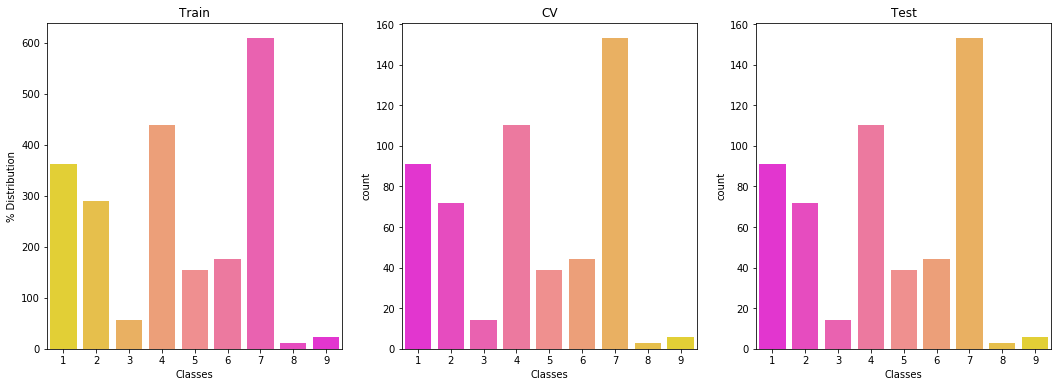

In [14]:


fig, axs = plt.subplots(1,3,figsize=(18,6)) 
pl0=sns.countplot(x='Class', data=train_df,palette='spring_r',ax=axs[0])
axs[0].set(xlabel='Classes', 
       ylabel='% Distribution',title='Train')

pl1=sns.countplot(x='Class', data=cv_df,palette='spring',ax=axs[1])
axs[1].set(xlabel='Classes',title='CV')

pl2=sns.countplot(x='Class', data=cv_df,palette='spring',ax=axs[2])
axs[2].set(xlabel='Classes',title='Test')

plt.legend();
plt.show();

In [16]:



print('\x1b[1;03;55;55m')
print("Distribution of YValues")
col_name="Class"
values_count_tr = pd.DataFrame(train_df[col_name].value_counts())    
values_count_tr.columns = ['Train_count'] 
values_count_tr[col_name] = [ str(i) for i in values_count_tr.index ]
values_count_tr['Train_percent'] = values_count_tr['Train_count'].div(values_count_tr['Train_count'].sum()).multiply(100).round(2) 

values_count_cv = pd.DataFrame(cv_df[col_name].value_counts())    
values_count_cv.columns = ['CV_count'] 
values_count_cv[col_name] = [ str(i) for i in values_count_cv.index ]
values_count_cv['CV_percent'] = values_count_cv['CV_count'].div(values_count_cv['CV_count'].sum()).multiply(100).round(2) 


values_count_te = pd.DataFrame(test_df[col_name].value_counts())    
values_count_te.columns = ['Test_count'] 
values_count_te[col_name] = [ str(i) for i in values_count_te.index ]
values_count_te['Test_percent'] = values_count_te['Test_count'].div(values_count_te['Test_count'].sum()).multiply(100).round(2) 
 
merge_CV_Train = pd.merge(values_count_tr, values_count_cv,on='Class', how='left')
result_count=pd.merge(merge_CV_Train, values_count_te,on='Class', how='left')

result_count= result_count.reindex_axis([col_name,'Train_percent','CV_percent','Test_percent'],axis=1)
result_count.reset_index(drop=True,inplace=True) 

x =  PrettyTable(header_style='upper', padding_width=2)     
for col in result_count.columns:
    x.add_column(column=result_count[col],fieldname=col)
print(x) 


Distribution of YValues
+---------+-----------------+--------------+----------------+
|  CLASS  |  TRAIN_PERCENT  |  CV_PERCENT  |  TEST_PERCENT  |
+---------+-----------------+--------------+----------------+
|    7    |      28.67      |    28.76     |     28.72      |
|    4    |      20.67      |    20.68     |      20.6      |
|    1    |      17.09      |    17.11     |     17.14      |
|    2    |      13.61      |    13.53     |     13.68      |
|    6    |       8.29      |     8.27     |      8.27      |
|    5    |       7.3       |     7.33     |      7.22      |
|    3    |       2.68      |     2.63     |      2.71      |
|    9    |       1.13      |     1.13     |      1.05      |
|    8    |       0.56      |     0.56     |      0.6       |
+---------+-----------------+--------------+----------------+


<b>We get same distribution of classes in all three datasets (train, Cv and test)

<h2>Find logloss for random model 
<h4>our model's logloss must e less than random model's logloss - this will make sure that our model is better than random assumptions

<b> 
In a 'Random' Model, we generate the NINE class probabilites randomly such that they sum to 1. 

Log loss on Cross Validation Data using Random Model 2.49230983565
Log loss on Test Data using Random Model 2.44055615113
-------------------- Confusion matrix --------------------


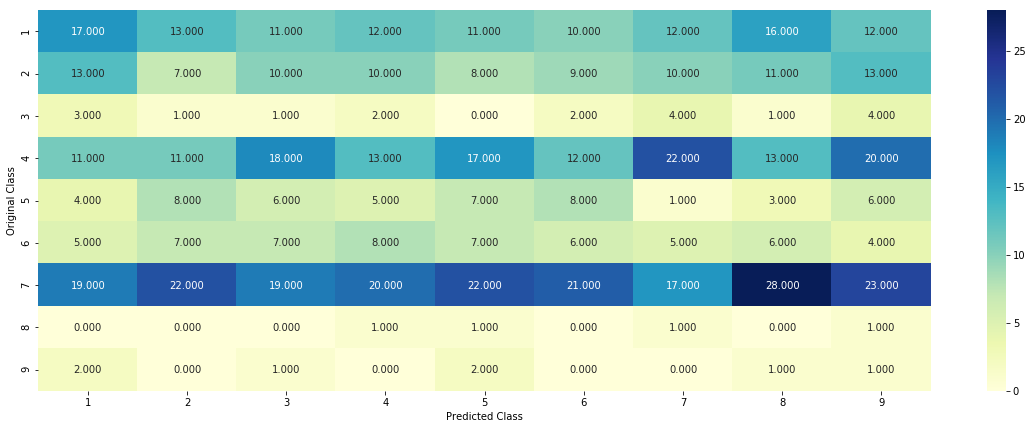

-------------------- Precision matrix (Columm Sum=1) --------------------


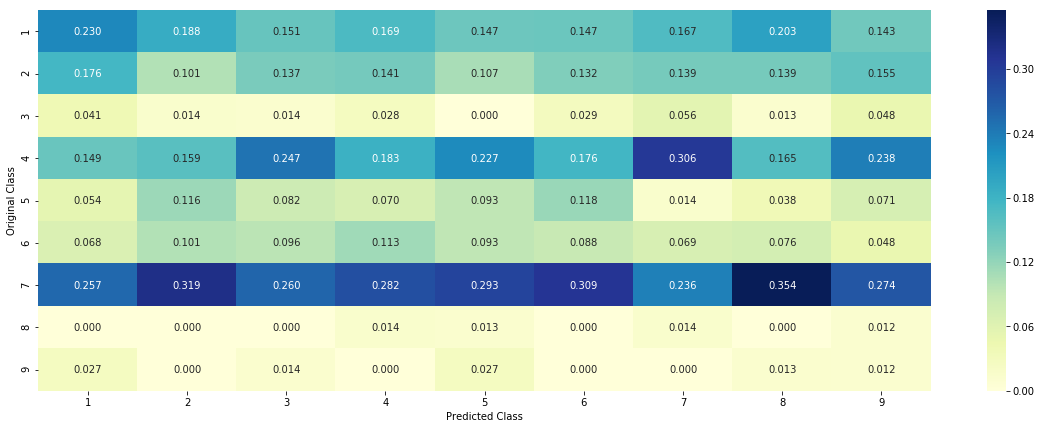

-------------------- Recall matrix (Row sum=1) --------------------


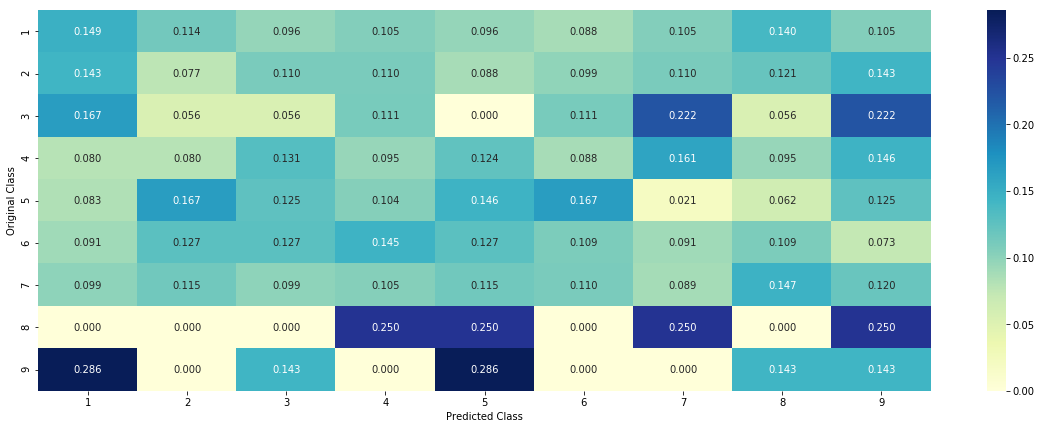

In [149]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))


# Test-Set error.
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))
predicted_y =np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)


<h2>Univariate Analysis</h2>

when we caculate the probability of a feature belongs to any particular class, we apply laplace smoothing
<li>(numerator + 10\*alpha) / (denominator + 90\*alpha) </li>

<h4>Univariate Analysis on Gene Feature</h3><br>
<p style="font-size:18px;"> <b> Gene, What type of feature it is ?</p>
<p style="font-size:16px;"><b>  Gene is a categorical variable </p>
<p style="font-size:18px;"> <b>  How many categories are there and How they are distributed?</p>

Number of Unique values 240
BRCA1     173
TP53      114
EGFR       92
PTEN       79
BRCA2      75
BRAF       64
KIT        57
ERBB2      45
ALK        43
PDGFRA     42
Name: Gene, dtype: int64


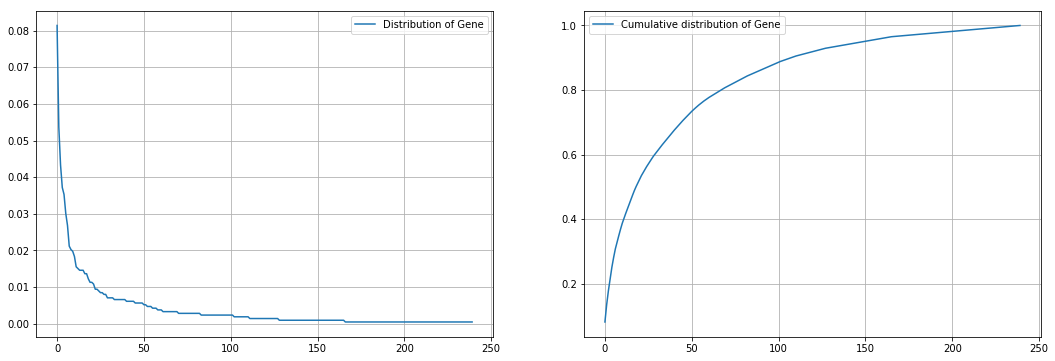

In [18]:
findDistribution(col_name='Gene',data=train_df)


<p style="font-size:18px;"> <b> How to featurize this Gene feature ?</p>

<p style="font-size:16px;"><b>
<ol><li>One hot Encoding</li><li>Response coding</li></ol></p>
<p> We will be using both these methods to featurize the Gene Feature </p>

In [4]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

In [20]:
print("train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature:", train_gene_feature_responseCoding.shape)

train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature: (2124, 9)


In [6]:
# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [23]:
Gene_count = Counter(list(train_df['Gene']))
Gene_count.most_common(10),train_df.Gene.describe()

([('BRCA1', 173),
  ('TP53', 114),
  ('EGFR', 92),
  ('PTEN', 79),
  ('BRCA2', 75),
  ('BRAF', 64),
  ('KIT', 57),
  ('ERBB2', 45),
  ('ALK', 43),
  ('PDGFRA', 42)],
 count      2124
 unique      240
 top       BRCA1
 freq        173
 Name: Gene, dtype: object)

In [24]:
print("train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature:", train_gene_feature_onehotCoding.shape)

train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature: (2124, 239)


<h4> How good is this gene feature  in predicting y_i?

There are many ways to estimate how good a feature is, in predicting y_i. One of the good methods is to build a proper ML model using just this feature. In this case, we will build a logistic regression model using only Gene feature (one hot encoded) to predict y_i.

For values of alpha =  1e-05 The log loss is: 1.40010195844
For values of alpha =  0.0001 The log loss is: 1.19934057166
For values of alpha =  0.001 The log loss is: 1.21821980606
For values of alpha =  0.01 The log loss is: 1.34059434376
For values of alpha =  0.1 The log loss is: 1.43841992083
For values of alpha =  1 The log loss is: 1.4750697193


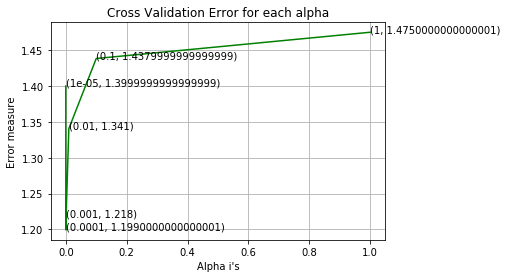

For values of best alpha =  0.0001 The train log loss is: 1.03274934176
For values of best alpha =  0.0001 The cross validation log loss is: 1.19934057166
For values of best alpha =  0.0001 The test log loss is: 1.21083677273


In [26]:
relationWithclass(train_gene_feature_onehotCoding,y_train,cv_gene_feature_onehotCoding,y_cv,test_gene_feature_onehotCoding,y_test)

<b> Gene feature does have a failry good log loss than the random model log loss, also the train test and cv log loss do not differ much

<h4><b> Is the Gene feature stable across all the data sets (Test, Train, Cross validation)?<br>
<h4><b> Yes, it is. Otherwise, the CV and Test errors would be significantly more than train error. 

In [27]:
unique_genes=train_df.Gene.value_counts()
print("Q6. How many data points in Test and CV datasets are covered by the ", unique_genes.shape[0], " genes in train dataset?")

test_coverage=test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage=cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Q6. How many data points in Test and CV datasets are covered by the  240  genes in train dataset?
Ans
1. In test data 644 out of 665 : 96.84210526315789
2. In cross validation data 522 out of  532 : 98.1203007518797


<h2> How is gene related to class?</h2><br>
<h4> For this we will find probablity of a getting a particular class- byassuming feature independence and considering only one featture that is Gene

In [19]:
get_feature_dict('Gene')

In [20]:
train_df[['GeneClass']] = train_df[['GeneClass']].apply(pd.to_numeric)
cv_df[['GeneClass']] = cv_df[['GeneClass']].apply(pd.to_numeric)
test_df[['GeneClass']] = test_df[['GeneClass']].apply(pd.to_numeric)
 

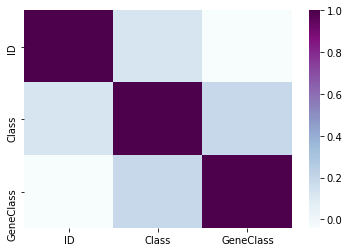

In [30]:
sns.heatmap(data=train_df.corr(method='spearman'),cmap='BuPu')
plt.show()

<h4> What is seen here, is that  GeneClass - our derived feature do depend on the depenedent feature (Class)
let us keep it for now in our data set

<h2>Univariate Analysis on Variation Feature</h3>

<h4> <b> Variation, What type of feature is it ?</h4>
<h4><b>Variation is a categorical variable </h4>
<h4> <b> How many categories are there?</h4>

Number of Unique values 1918
Truncating_Mutations         69
Amplification                57
Deletion                     39
Fusions                      21
Overexpression                4
G12V                          3
Q61R                          3
E542K                         2
R173C                         2
Promoter_Hypermethylation     2
Name: Variation, dtype: int64


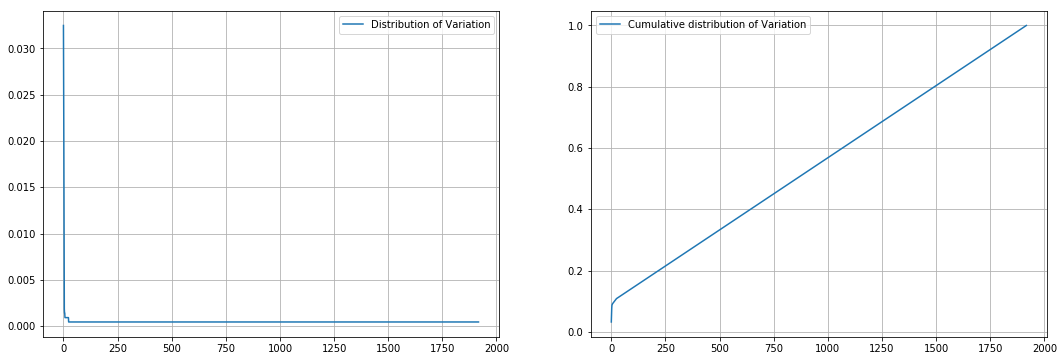

In [28]:
findDistribution('Variation',train_df)

<p style="font-size:18px;"> <b> How to featurize this Variation feature ?</p>

<p style="font-size:16px;"><b>
<ol><li>One hot Encoding</li><li>Response coding</li></ol></p>
<p> We will be using both these methods to featurize the Variation Feature </p>

In [6]:
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

In [37]:
print("train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature:", train_variation_feature_responseCoding.shape)

train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature: (2124, 9)


In [7]:
# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

In [39]:
print("train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature:", train_variation_feature_onehotCoding.shape)

train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature: (2124, 1970)


<h4> <b>How good is this Variation feature  in predicting y_i?

Let's build a model just like the earlier!

For values of alpha =  1e-05 The log loss is: 1.72613764707
For values of alpha =  0.0001 The log loss is: 1.71490043485
For values of alpha =  0.001 The log loss is: 1.71468303899
For values of alpha =  0.01 The log loss is: 1.72186917013
For values of alpha =  0.1 The log loss is: 1.73089578929
For values of alpha =  1 The log loss is: 1.73321534459


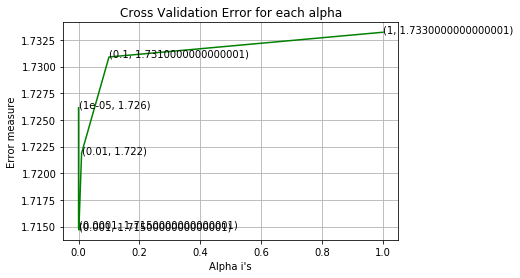

For values of best alpha =  0.001 The train log loss is: 1.0643012552
For values of best alpha =  0.001 The cross validation log loss is: 1.71468303899
For values of best alpha =  0.001 The test log loss is: 1.7311922159


In [170]:
realtionWithclass(train_variation_feature_onehotCoding,y_train,cv_variation_feature_onehotCoding,y_cv,test_variation_feature_onehotCoding,y_test)

<p style="font-size:18px;"> <b>Q11.</b> Is the Variation feature stable across all the data sets (Test, Train, Cross validation)?</p>
<p style="font-size:16px;"> <b>Ans.</b> Not sure! But lets be very sure using the below analysis. </p>

In [27]:
unique_variations=train_df.Variation.value_counts()
print("Q12. How many data points are covered by total ", unique_variations.shape[0], " genes in test and cross validation data sets?")
test_coverage=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage=cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Q12. How many data points are covered by total  1937  genes in test and cross validation data sets?
Ans
1. In test data 69 out of 665 : 10.37593984962406
2. In cross validation data 66 out of  532 : 12.406015037593985


<h3><b> Find how variation is related to class</h3><br>
<b> Same as in Gene feature, we will now assume that variation is the only feature for predicting the class and will find different probabilities

In [4]:
get_feature_dict('Variation')

In [5]:
train_df[['VariationClass']] = train_df[['VariationClass']].apply(pd.to_numeric)
cv_df[['VariationClass']] = cv_df[['VariationClass']].apply(pd.to_numeric)
test_df[['VariationClass']] = test_df[['VariationClass']].apply(pd.to_numeric)
train_df.dtypes

ID                int64  
Gene              object 
Variation         object 
Class             int64  
TEXT              object 
GeneClass         float64
Gene_Variation    object 
LastWord          object 
IMP_WORDS         object 
VariationClass    float64
dtype: object

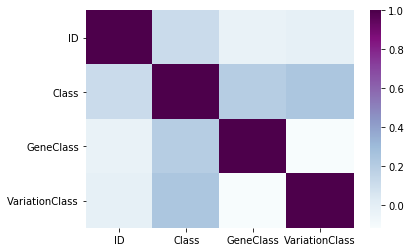

In [17]:
sns.heatmap(data=train_df.corr(method='spearman'),cmap='BuPu')
plt.show()

<b> Again , what we can see is that - variationClass our derived feature do affect the labed feature.<br>
<b> We already knew that variation feature is non uniformly distributed in the dataset - that is we have higher number of distinct varioation feautures in dataset

<h2>
<li>Check both genes and variation together  

In [23]:
train_df['Gene_Variation']= train_df.Gene+' '+train_df.Variation
cv_df['Gene_Variation']= cv_df.Gene+' '+cv_df.Variation
test_df['Gene_Variation']= test_df.Gene+' '+test_df.Variation

Number of Unique values 2124
BRCA1 V1736G                 1
NFE2L2 V32G                  1
FLT3 Y599_D600insEYEYEYEY    1
NOTCH1 L1593P                1
FGFR1 A263V                  1
TP53 R337C                   1
PIM1 E124Q                   1
BAP1 E685V                   1
MLH1 R755S                   1
BRCA1 C39R                   1
Name: Gene_Variation, dtype: int64


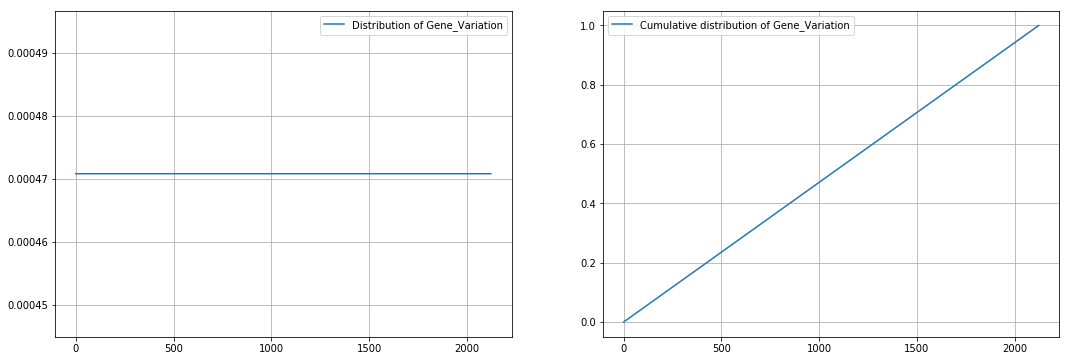

In [33]:
findDistribution(col_name='Gene_Variation',data=train_df)

In [76]:
print("Number of rows in train data", train_df.shape[0])
print("Number of unique values in new generated feature ", train_df.Gene_Variation.value_counts().shape[0])

Number of rows in train data 2124
Number of unique values in new generated feature  2124


<b>If we combine these two features -  a new unique feature is generated which is unique for whole data (train data) <br><br>
<b>As seen earlier - same gene and text with different variation resulted into different class - which implies that variation feature creates a unique combination with gene - we can see that variation feature is very important - it decides the class - but it is very much spread in the data<br>



In [10]:
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_Gene_Variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene_Variation", train_df))
# test gene feature
test_Gene_Variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene_Variation", test_df))
# cross validation gene feature
cv_Gene_Variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene_Variation", cv_df))

In [36]:
print("train_Gene_Variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature:", train_Gene_Variation_feature_responseCoding.shape)

train_Gene_Variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature: (2124, 9)


In [9]:
# one-hot encoding of variation feature.
genevariation_vectorizer = CountVectorizer()
train_genevariation_feature_onehotCoding = genevariation_vectorizer.fit_transform(train_df['Gene_Variation'])
test_genevariation_feature_onehotCoding = genevariation_vectorizer.transform(test_df['Gene_Variation'])
cv_genevariation_feature_onehotCoding = genevariation_vectorizer.transform(cv_df['Gene_Variation'])

In [12]:
print("train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature:", train_genevariation_feature_onehotCoding.shape)

train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature: (2124, 2188)


In [59]:
unique_genevars=train_df.Gene_Variation.value_counts()
print("Q6. How many data points in Test and CV datasets are covered by the ", unique_genevars.shape[0], " gene variations in train dataset?")

test_coverage=test_df[test_df['Gene_Variation'].isin(list(set(train_df['Gene_Variation'])))].shape[0]
cv_coverage=cv_df[cv_df['Gene_Variation'].isin(list(set(train_df['Gene_Variation'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Q6. How many data points in Test and CV datasets are covered by the  2124  gene variations in train dataset?
Ans
1. In test data 0 out of 665 : 0.0
2. In cross validation data 0 out of  532 : 0.0


<h3> As Variation feature is important- let us check for any details that we can get from the data

In [18]:
train_df.loc[1500:1520,'Variation']

1500                   E475K
3110                Deletion
2497                  G1706E
2300                   S646F
2258                   M134L
2384                   P491S
1433                   R121Q
882                    N659K
2613                  T1720I
1863                  L2431P
1174                   E545Q
2071                  Y1295A
540                    D450E
3202    Truncating_Mutations
1591                    Y98H
1655    E598_Y599insDVDFREYE
123                    E622D
1003                 V128del
1819                    E40T
558                    R287A
238                  EGFRvIV
1101                    C91S
1942                   E127G
1198           Amplification
2204                    Y65C
2094                   Y901C
2984            K558delinsNP
2238                    H61D
2107                     M1K
2216                    D92E
                ...         
1554                  G1286R
1113                Deletion
251                    L833V
1815          

<h4>By looking at the data at one glance - It seems that mainly 3 kinds of variations are there <br>
<li>Alphabetic
<li>Alpha numeric
<li>the one that ends with "Fusion"<br><br>
<b>Let us find distribution of different types of variations

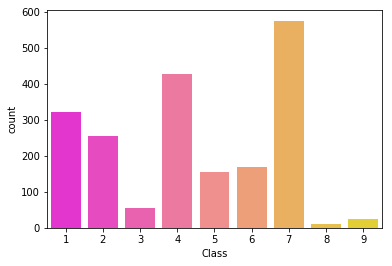

In [20]:
#Variation that contains alphanumeric characters
temp0=train_df[~train_df['Variation'].str.isalpha()]
sns.countplot(x='Class', data=temp0,palette='spring')
plt.show()

In [34]:
print(temp0.Gene.value_counts().head(30))
temp0.head()

BRCA1     167
TP53      110
EGFR       94
PTEN       81
BRCA2      77
KIT        62
BRAF       57
ERBB2      44
ALK        44
PDGFRA     38
PIK3CA     38
TSC2       30
FLT3       30
KRAS       28
MLH1       28
MTOR       28
CDKN2A     27
FGFR3      26
MAP2K1     26
FGFR2      25
RET        21
NOTCH1     20
MET        19
VHL        19
CTNNB1     18
JAK2       17
SPOP       16
ABL1       16
MSH2       16
PTPRT      16
Name: Gene, dtype: int64


,ID,Gene,Variation,Class,TEXT,GeneClass,IMP_WORDS,VariationClass
2751,2751,BRAF,N486_P490del,2,identifi ed previously undiscovered braf frame...,0.403509,cells variants cell mutation pten cancer egfr ...,0.120879
2040,2040,MAP2K2,S222D,6,abstract cardio facio cutaneous cfc syndrome s...,0.333333,cells cell mutation cancer patients protein ac...,0.119565
1363,1363,AKT1,N53A,7,protein kinase v akt murine thymoma viral onco...,0.642857,cells cell mutation pten cancer patients prote...,0.120879
1762,1762,IDH1,I99M,5,introduction somatic mutations human cytosolic...,0.461538,cells variants cell mutation cancer patients p...,0.120879
627,627,FBXW7,T205A,2,fbw7 substrate recognition component scf skp1 ...,0.090909,cells cell mutation cancer patients p53 protei...,0.120879


<b> Again, Variation which are having alphabets and numbers - are spread acorss all the classes and also Gene.
So, Nothing can be concluded from this

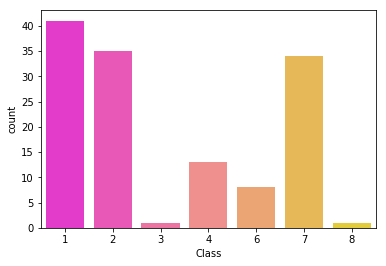

In [24]:
#Variation that contains only alphabets
temp1=train_df[train_df['Variation'].str.isalpha()]
sns.countplot(x='Class', data=temp1,palette='spring')
plt.show()

In [33]:
print(temp1.Gene.value_counts().head(30))
temp1.head()

EGFR       4
FGFR1      2
EP300      2
KMT2A      2
JAK2       2
RAF1       2
CDKN2B     2
EZH2       2
NTRK1      2
FGFR3      2
KRAS       2
RHOA       2
RUNX1      2
NKX2-1     2
AKT3       2
MET        2
AXL        1
FOXL2      1
IKBKE      1
NPM1       1
CDKN2C     1
BARD1      1
ROS1       1
SMARCB1    1
CREBBP     1
CCNE1      1
FGFR2      1
MYCN       1
MEN1       1
CDK4       1
Name: Gene, dtype: int64


,ID,Gene,Variation,Class,TEXT,GeneClass,IMP_WORDS,VariationClass
2113,2113,SRC,Amplification,2,non receptor tyrosine kinase c src hereafter r...,0.500000,cells cell mutation cancer egfr patients prote...,0.172662
1088,1088,EZH2,Amplification,7,ezh2 member polycomb group genes important cel...,0.285714,cells cell mutation cancer egfr patients p53 p...,0.266187
1627,1627,VHL,Deletion,1,autosomal dominantly inherited disorder von hi...,0.400000,brca1 cells variants cell mutation cancer pati...,0.352113
1079,1079,MDM2,Amplification,7,abstract p53 tumor suppressor gene inactivated...,1.000000,cells variants cell mutation cancer patients p...,0.266187
281,281,NKX2-1,Amplification,7,used high resolution array analysis discover r...,0.400000,cells cell mutation pten cancer egfr patients ...,0.266187


In [27]:

def findLastWord(variation):
    return (variation.split('_')[-1]) 

train_df['LastWord'] = train_df['Variation'].apply(findLastWord)        
cv_df['LastWord'] = cv_df['Variation'].apply(findLastWord)        
test_df['LastWord'] = test_df['Variation'].apply(findLastWord)        


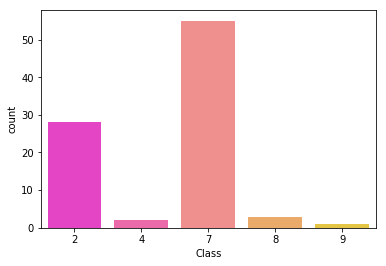

In [122]:
#Variation that contains only alphabets
temp3=train_df[train_df['LastWord']=='Fusion']
sns.countplot(x='Class', data=temp3,palette='spring')
plt.show()

In [127]:
print(temp3.Gene.value_counts().head(30))
temp3.head()

PDGFRB     12
EWSR1       6
NTRK1       6
ROS1        6
BRAF        5
JAK2        4
NTRK3       3
FGFR1       3
ALK         3
BCOR        3
PDGFRA      3
RAF1        3
RUNX1       2
EGFR        2
ESR1        2
NKX2-1      2
EP300       2
FGFR3       2
ERG         2
ETV6        2
NOTCH1      2
CIC         1
TMPRSS2     1
PAX8        1
ABL1        1
PIK3CB      1
MYC         1
MET         1
NSD1        1
ERBB4       1
Name: Gene, dtype: int64


,ID,Gene,Variation,Class,TEXT,GeneClass,IMP_WORDS,VariationClass,LastWord
1057,1057,EWSR1,EWSR1-FEV_Fusion,2,result chromosome translocations ews gene fuse...,0.571429,protein tumor domain expression binding tumors...,0.120879,Fusion
1064,1064,EWSR1,EWSR1-CREB1_Fusion,2,many soft tissue sarcomas chromosomal transloc...,0.571429,cells variants cell patients protein activity ...,0.120879,Fusion
1063,1063,EWSR1,EWSR1-NR4A3_Fusion,7,approximately 75 extraskeletal myxoid chondros...,0.428571,cells cell mutation cancer p53 protein activit...,0.120879,Fusion
2752,2752,BRAF,AKAP9-BRAF_Fusion,7,genes crucial cancer development mutated via v...,0.438596,cells variants cell mutation cancer patients p...,0.120879,Fusion
947,947,PDGFRB,CEP85L-PDGFRB_Fusion,2,fusion genes involving tyrosine kinases tks id...,0.714286,brca1 cells variants cell mutation cancer pati...,0.120879,Fusion


Number of Unique values 1810
Fusion            89
Mutations         61
Deletion          53
Amplification     49
Fusions           22
Overexpression     5
K558del            4
G12V               4
splice             4
Q61H               3
Name: LastWord, dtype: int64


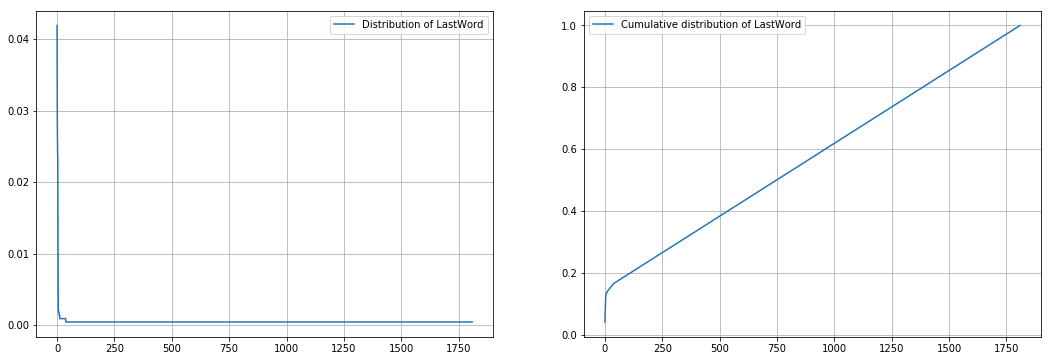

In [125]:
findDistribution('LastWord',train_df)

<h2>Let us featurize the LastWord feature by one hot encoding and response coding

In [12]:
# one-hot encoding of variation feature.
lastWord_vectorizer = CountVectorizer()
train_LastWord_feature_onehotCoding = lastWord_vectorizer.fit_transform(train_df['LastWord'])
test_LastWord_feature_onehotCoding = lastWord_vectorizer.transform(test_df['LastWord'])
cv_LastWord_feature_onehotCoding = lastWord_vectorizer.transform(cv_df['LastWord'])

In [14]:
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_LastWord_feature_responseCoding = np.array(get_gv_feature(alpha, "LastWord", train_df))
# test gene feature
test_LastWord_feature_responseCoding = np.array(get_gv_feature(alpha, "LastWord", test_df))
# cross validation gene feature
cv_LastWord_feature_responseCoding = np.array(get_gv_feature(alpha, "LastWord", cv_df))

<h3>Univariate Analysis on Text Feature</h3>

How many unique words are present in train data?

In [30]:
#1. Find unique words
distinctWords = set()
train_df['TEXT'].str.lower().str.split().apply(distinctWords.update)
print ("Total unique words in train data",len(distinctWords)) 

Total unique words in train data 125941


<b>Featurize data by TF IDF

In [29]:
tf_idf_vect_Text = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf_Text = tf_idf_vect_Text.fit_transform(train_df['TEXT'].values)
final_tf_idf_test_Text= tf_idf_vect_Text.transform(test_df['TEXT'].values)  
final_tf_idf_cv_Text = tf_idf_vect_Text.transform(cv_df['TEXT']) 


train_x_normalize_Text = normalize(final_tf_idf_Text, axis=0)
cv_x_normalize_Text= normalize(final_tf_idf_cv_Text, axis=0)
test_x_normalize_Text= normalize(final_tf_idf_test_Text, axis=0)

<b> Find top 1000 important word for each document in the data

In [32]:
sc=display_scores(tf_idf_vect_Text, final_tf_idf_Text)
words=[i[0] for i in sc]  

In [35]:
findImpWords(train_df,train_df['TEXT'])
findImpWords(cv_df,cv_df['TEXT'])
findImpWords(test_df,test_df['TEXT'])

In [36]:
train_df.head(5)

,ID,Gene,Variation,Class,TEXT,GeneClass,Gene_Variation,LastWord,IMP_WORDS
2576,2576,BRCA1,G1770V,4,brca1 brca2 account majority hereditary breast...,0.180124,BRCA1 G1770V,G1770V,brca1 cells variants mutation cell cancer pati...
2373,2373,PTPN11,E76K,7,noonan syndrome ns characterized short stature...,0.647059,PTPN11 E76K,E76K,cells mutation cell patients protein activity ...
2240,2240,PTEN,R173P,4,tumor suppressor gene pten frequently mutated ...,0.901235,PTEN R173P,R173P,cells mutation cell pten cancer protein activi...
45,45,PTPRT,V648G,1,receptor protein tyrosine phosphatase ptprt pt...,0.625000,PTPRT V648G,V648G,cells mutation cell cancer protein activity ki...
2644,2644,BRCA1,R71G,6,published analyses effects missense brca1 gene...,0.204969,BRCA1 R71G,R71G,brca1 cells variants mutation cell cancer pati...


<b> A column added IMP_WORDS that shows top 100 words
<br>
<b>Featurize IMP_WORDS with TFDF

In [10]:
tf_idf_vect_Imp = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf_Imp = tf_idf_vect_Imp.fit_transform(train_df['IMP_WORDS'].values)
final_tf_idf_test_Imp = tf_idf_vect_Imp.transform(test_df['IMP_WORDS'].values)  
final_tf_idf_cv_Imp = tf_idf_vect_Imp.transform(cv_df['IMP_WORDS']) 

#Normalize the data
train_x_normalize_Imp = normalize(final_tf_idf_Imp, axis=0)
cv_x_normalize_Imp= normalize(final_tf_idf_cv_Imp, axis=0)
test_x_normalize_Imp= normalize(final_tf_idf_test_Imp, axis=0)

In [93]:
def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['IMP_WORDS'].split():
            dictionary[word] +=1
    return dictionary
dict_list = [] 
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list
 
total_dict = extract_dictionary_paddle(train_df)

<b>Response coding of IMP_WORDS Feature

In [95]:
#response coding of text features
train_IMP_feature_responseCoding  = get_text_responsecoding(train_df)
test_IMP_feature_responseCoding  = get_text_responsecoding(test_df)
cv_IMP_feature_responseCoding  = get_text_responsecoding(cv_df)

# https://stackoverflow.com/a/16202486
# we convert each row values such that they sum to 1  
train_IMP_feature_responseCoding = (train_IMP_feature_responseCoding.T/train_IMP_feature_responseCoding.sum(axis=1)).T
test_IMP_feature_responseCoding = (test_IMP_feature_responseCoding.T/test_IMP_feature_responseCoding.sum(axis=1)).T
cv_IMP_feature_responseCoding = (cv_IMP_feature_responseCoding.T/cv_IMP_feature_responseCoding.sum(axis=1)).T

<b> Find how imp words of text are related to class labels


For values of alpha =  1e-05 The log loss is: 1.48983877216
For values of alpha =  0.0001 The log loss is: 1.50828611459
For values of alpha =  0.001 The log loss is: 1.46565222643
For values of alpha =  0.01 The log loss is: 1.18735917787
For values of alpha =  0.1 The log loss is: 1.17395348774
For values of alpha =  1 The log loss is: 1.18949665471


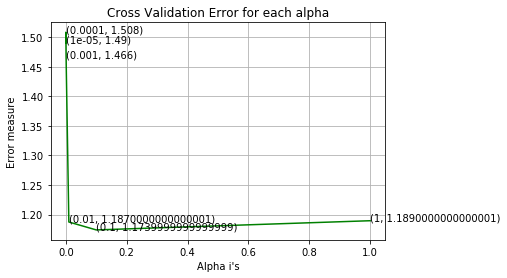

For values of best alpha =  0.1 The train log loss is: 0.55238784027
For values of best alpha =  0.1 The cross validation log loss is: 1.17395348774
For values of best alpha =  0.1 The test log loss is: 1.10966769252


In [39]:
relationWithclass(train_x_normalize_Text,y_train,cv_x_normalize_Text,y_cv,test_x_normalize_Text,y_test)

For values of alpha =  1e-05 The log loss is: 1.46762345529
For values of alpha =  0.0001 The log loss is: 1.45316966143
For values of alpha =  0.001 The log loss is: 1.27307781128
For values of alpha =  0.01 The log loss is: 1.26759983874
For values of alpha =  0.1 The log loss is: 1.7814494585
For values of alpha =  1 The log loss is: 2.32308443719


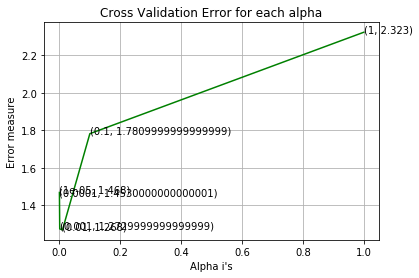

For values of best alpha =  0.01 The train log loss is: 0.589219958661
For values of best alpha =  0.01 The cross validation log loss is: 1.26759983874
For values of best alpha =  0.01 The test log loss is: 1.09227119588


In [40]:
relationWithclass(train_x_normalize_Imp,y_train,cv_x_normalize_Imp,y_cv,test_x_normalize_Imp,y_test)

<b>Is the Text feature stable across all the data sets (Test, Train, Cross validation)?<br> 

In [159]:
len1,len2 = get_intersec_text(test_df,'IMP_WORDS')
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df,'IMP_WORDS')
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

98.166 % of word of test data appeared in train data
98.218 % of word of Cross Validation appeared in train data


In [160]:
len1,len2 = get_intersec_text(test_df,'TEXT')
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df,'TEXT')
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

96.332 % of word of test data appeared in train data
97.816 % of word of Cross Validation appeared in train data


<h2>Machine Learning Models</h2>
<b><br>
<h4>We will use Gene, Variation, GeneClass, VariationClass, LastWord, IMPWords features for training different models
<br>
<h4>We will use both one hot encoded and response coded features with different models


In [13]:
train_df['GeneClass']=train_df['GeneClass'].fillna(0.111)
test_df['GeneClass']=test_df['GeneClass'].fillna(0.111)
cv_df['GeneClass']=cv_df['GeneClass'].fillna(0.111)

train_df['VariationClass']=train_df['VariationClass'].fillna(0.111)
test_df['VariationClass']=test_df['VariationClass'].fillna(0.111)
cv_df['VariationClass']=cv_df['VariationClass'].fillna(0.111)


train_GeneClass=np.matrix(train_df['GeneClass'])
train_VarClass=np.matrix(train_df['VariationClass'])
cv_GeneClass=np.matrix(cv_df['GeneClass'])
cv_VarClass=np.matrix(cv_df['VariationClass'])
test_GeneClass=np.matrix(test_df['GeneClass'])
test_VarClass=np.matrix(test_df['VariationClass'])



train_y = np.array(list(train_df['Class']))
test_y = np.array(list(test_df['Class']))
cv_y = np.array(list(cv_df['Class']))

y_train =  train_df['Class'] 
y_test = test_df['Class'] 
y_cv =  cv_df['Class'] 

#Stacking data
train_genevar_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding,train_GeneClass.T,train_VarClass.T,train_LastWord_feature_onehotCoding)) 
test_genevar_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding,test_GeneClass.T,test_VarClass.T,test_LastWord_feature_onehotCoding)) 
cv_genevar_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding,cv_GeneClass.T,cv_VarClass.T,cv_LastWord_feature_onehotCoding)) 

train_x_onehotCoding= hstack((train_genevar_onehotCoding,train_x_normalize_Imp)).tocsr() 
cv_x_onehotCoding= hstack((cv_genevar_onehotCoding,cv_x_normalize_Imp)).tocsr() 
test_x_onehotCoding= hstack((test_genevar_onehotCoding,test_x_normalize_Imp)).tocsr() 
 

In [97]:
train_gene_var_responseCoding= np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding,train_GeneClass.T,train_VarClass.T,train_LastWord_feature_responseCoding)) 
test_gene_var_responseCoding= np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding,test_GeneClass.T,test_VarClass.T,test_LastWord_feature_responseCoding)) 
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding,cv_GeneClass.T,cv_VarClass.T,cv_LastWord_feature_responseCoding)) 

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_IMP_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_IMP_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_IMP_feature_responseCoding))



Analysis of logistic regression with class balancing

+----------------+------------------------+
|     ALPHA      |        LOGLOSS         |
+----------------+------------------------+
|     1e-06      |     1.33705102253      |
|     1e-05      |     1.33838773294      |
|     0.0001     |     1.33411119302      |
|     0.001      |     1.11370136707      |
|      0.01      |     0.994144617915     |
|      0.1       |     1.08768063442      |
|      1.0       |     1.34699836783      |
|      10.0      |     1.56562436784      |
|     100.0      |     1.59859714289      |
+----------------+------------------------+


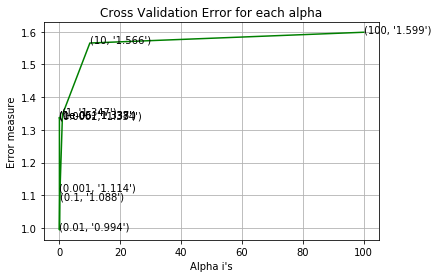


For values of best alpha =  0.01 The train log loss is: 0.495541340091
For values of best alpha =  0.01 The cross validation log loss is: 0.994144617915
For values of best alpha =  0.01 The test log loss is: 0.909068265101
Best alpha for model  LogRegBalance is  0.01
Log loss : 0.994144617915
Number of mis-classified points : 0.35714285714285715
-------------------- Confusion matrix --------------------


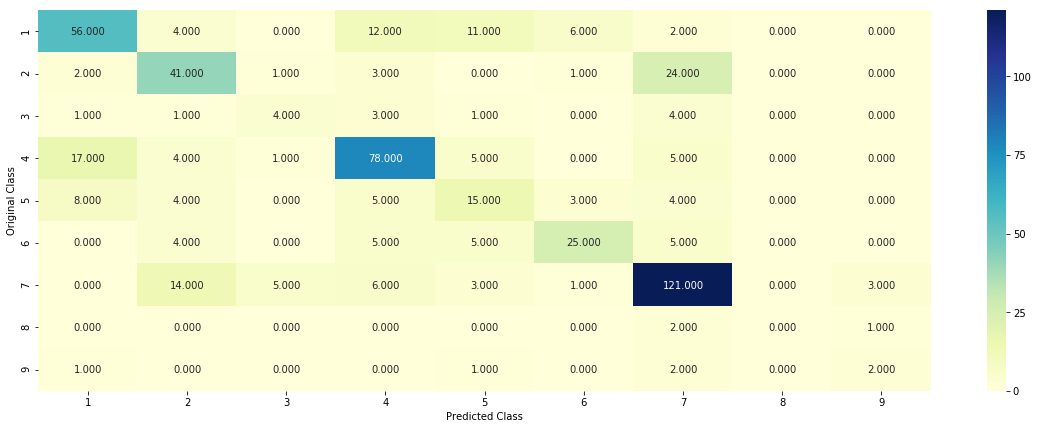

-------------------- Precision matrix (Columm Sum=1) --------------------


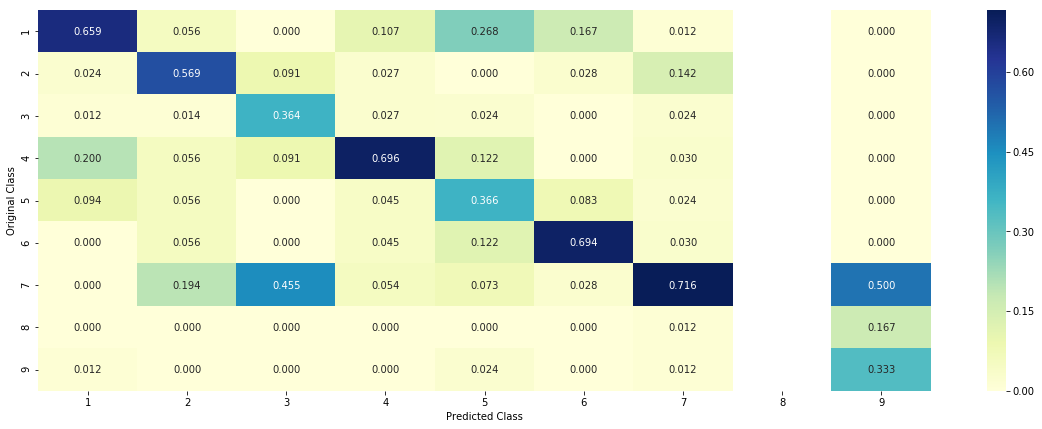

-------------------- Recall matrix (Row sum=1) --------------------


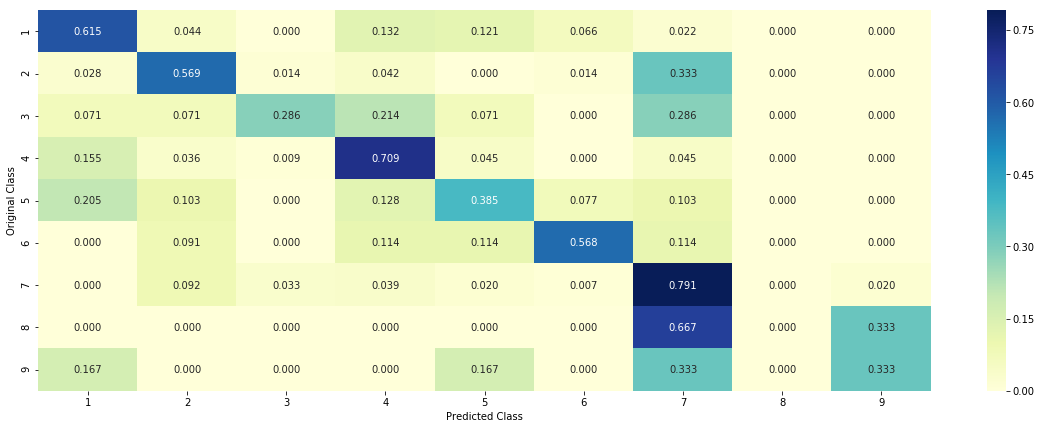

In [19]:
print('\x1b[1;03;55;55m')
print("Analysis of logistic regression with class balancing")
bestalpha=buildModel(train_x_onehotCoding,cv_x_onehotCoding,test_x_onehotCoding,'LogRegBalance')
clf_balance = SGDClassifier(class_weight='balanced', alpha=bestalpha , penalty='l2', loss='log', random_state=42)
sig_clfLogRegBlance=predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf_balance)

In [49]:
df_ClassBalanceLogLoss=testOnUnseenData(sig_clfLogRegBlance)
df_ClassBalanceLogLoss[df_ClassBalanceLogLoss['IsTrue']==False].shape

(224, 4)

<b>Total number of misclassified points for logistic regression with class balancing out of 665 is 224


Analysis of Naive bayes

+----------------+-----------------------+
|     ALPHA      |        LOGLOSS        |
+----------------+-----------------------+
|     1e-06      |     1.30386536842     |
|     1e-05      |     1.30643066713     |
|     0.0001     |     1.31391513186     |
|     0.001      |     1.33377140778     |
|      0.01      |     1.35648629669     |
|      0.1       |      1.3877690297     |
|      1.0       |     1.47363774712     |
|      10.0      |     1.58870766142     |
|     100.0      |      1.5487048711     |
+----------------+-----------------------+


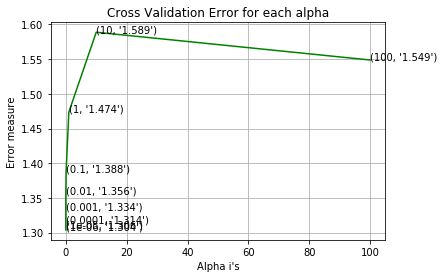


For values of best alpha =  1e-06 The train log loss is: 0.950882392317
For values of best alpha =  1e-06 The cross validation log loss is: 1.33705102253
For values of best alpha =  1e-06 The test log loss is: 1.28100557529
Best alpha for model  NB is  1e-06
Log Loss : 1.30386536842
Number of missclassified point : 0.3815789473684211
-------------------- Confusion matrix --------------------


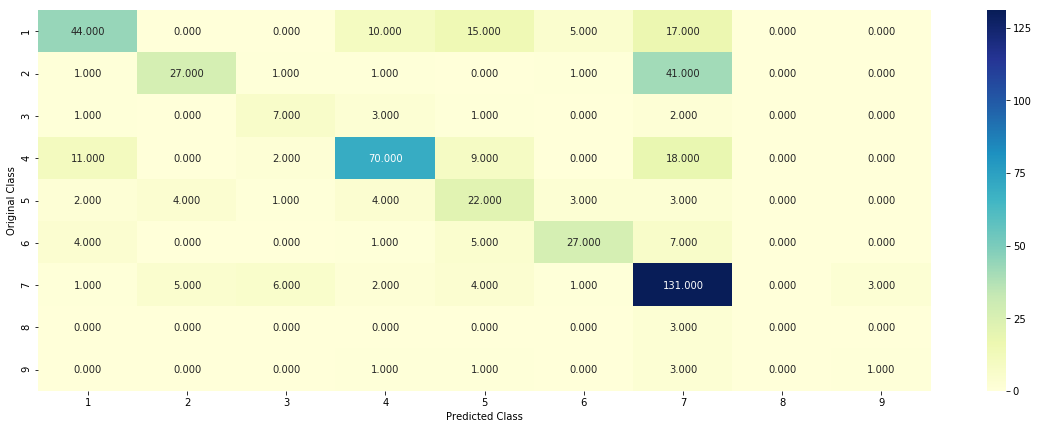

-------------------- Precision matrix (Columm Sum=1) --------------------


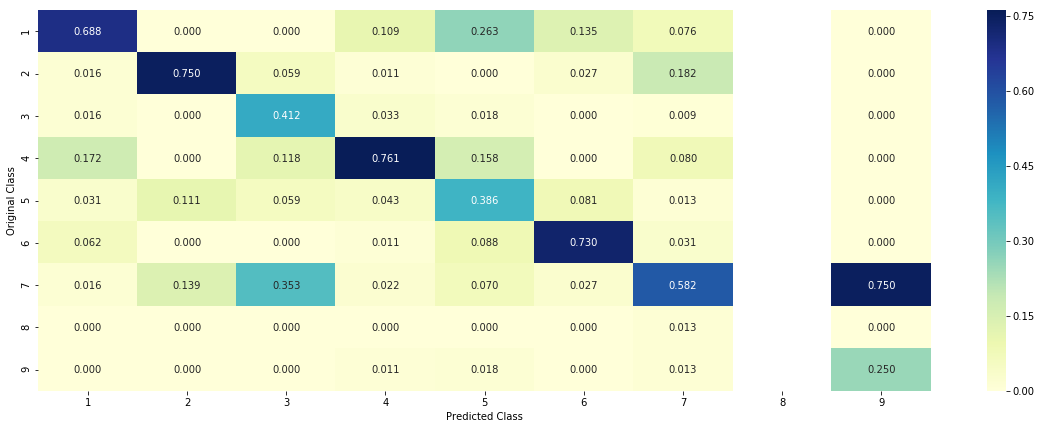

-------------------- Recall matrix (Row sum=1) --------------------


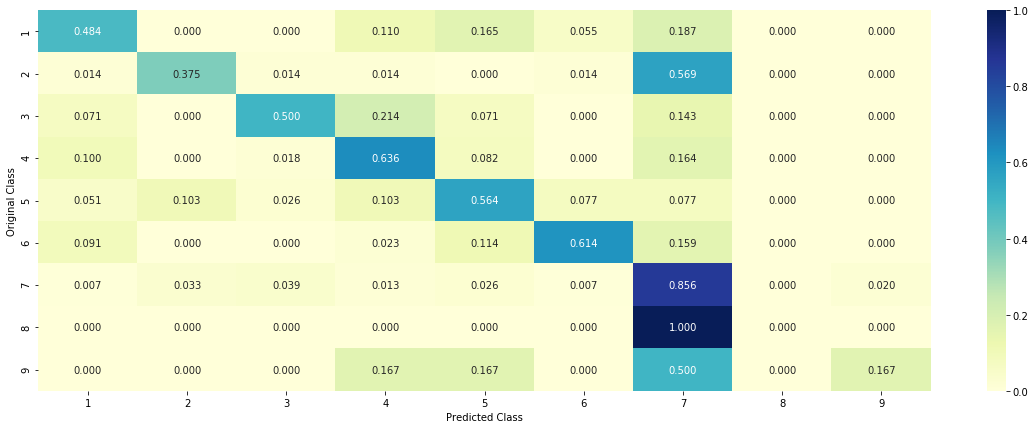

In [57]:
print('\x1b[1;03;55;55m')
print("Analysis of Naive bayes")

bestalpha=buildModel(train_x_onehotCoding,cv_x_onehotCoding,test_x_onehotCoding,'NB') 
clf_NB = MultinomialNB(alpha=bestalpha)
clf_NB.fit(train_x_onehotCoding, train_y)
sig_clf_NB = CalibratedClassifierCV(clf_NB, method="sigmoid")
sig_clf_NB.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf_NB.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf_NB.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf_NB.predict(cv_x_onehotCoding.toarray()))

In [59]:
df_NB=testOnUnseenData(sig_clf)
df_NB[df_NB['IsTrue']==False].shape

(236, 4)

<b>Total number of misclassified points for Naive bayes out of 665 is 236


Analysis of Random forest
+---------------+-----------------------+---------------------+
|     DEPTH     |        LOGLOSS        |     N_ESTIMATRS     |
+---------------+-----------------------+---------------------+
|       5       |     1.30050482887     |         100         |
|       10      |     1.25929707747     |         100         |
|       5       |     1.29440431822     |         200         |
|       10      |     1.24030305111     |         200         |
|       5       |     1.26939824962     |         500         |
|       10      |     1.23054703318     |         500         |
|       5       |     1.26173538274     |         1000        |
|       10      |     1.22095761135     |         1000        |
|       5       |     1.25866340898     |         2000        |
|       10      |     1.22088820066     |         2000        |
+---------------+-----------------------+---------------------+

For values of best estimator =  2000 The train log loss is: 0.659203962617
F

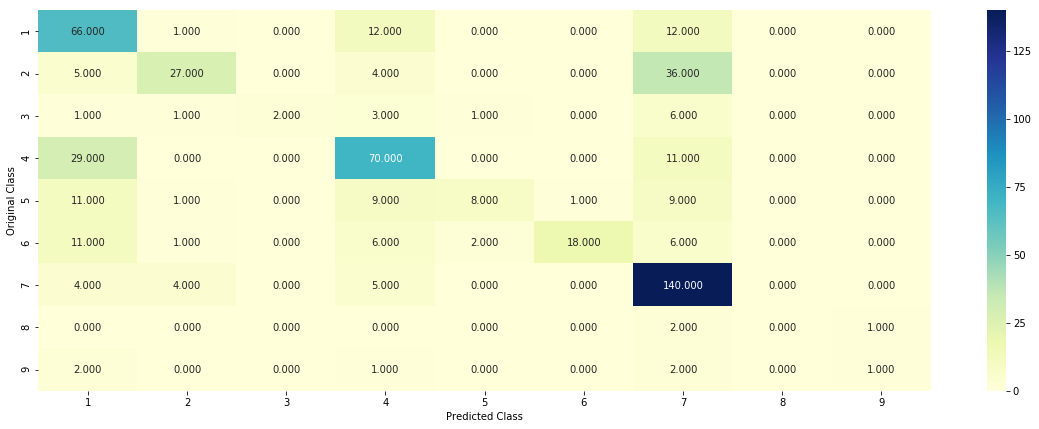

-------------------- Precision matrix (Columm Sum=1) --------------------


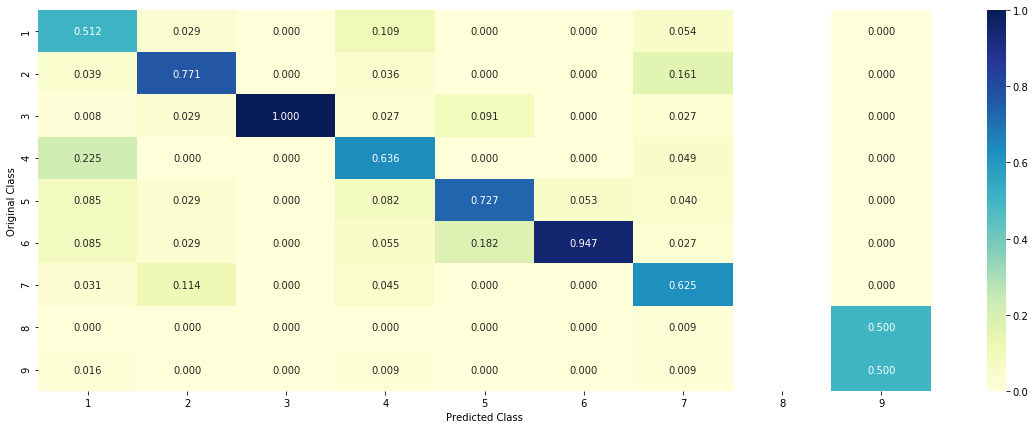

-------------------- Recall matrix (Row sum=1) --------------------


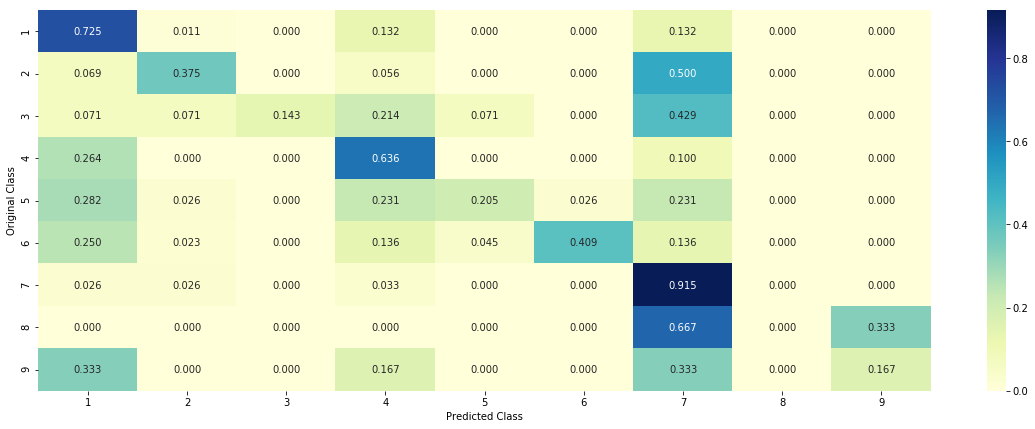

In [79]:
print('\x1b[1;03;55;55m')
print("Analysis of Random forest")
df_RF=buildRF(train_x_onehotCoding,cv_x_onehotCoding,test_x_onehotCoding)
 

In [82]:
df_RFFalse=testOnUnseenData(df_RF,df_RF)
df_RFFalse[df_RFFalse['IsTrue']==False].shape

(267, 4)

<b>Total number of misclassified points for Random forest with one hot encoding out of 665 is 267


Analysis of KNN

+---------------+-----------------------+
|     ALPHA     |        LOGLOSS        |
+---------------+-----------------------+
|       5       |     2.14660363001     |
|       11      |     1.84247264882     |
|       15      |     1.78153483017     |
|       21      |     1.74960567388     |
|       31      |     1.80417421797     |
|       41      |     1.84536184248     |
|       51      |     1.85666249491     |
|       99      |     1.29336454566     |
+---------------+-----------------------+


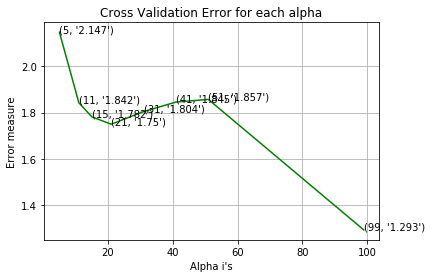


For values of best alpha =  99 The train log loss is: 1.74299092726
For values of best alpha =  99 The cross validation log loss is: 2.85636852649
For values of best alpha =  99 The test log loss is: 2.83568942938
Best alpha for model  KNN is  99
Log loss : 1.9138186216
Number of mis-classified points : 0.6484962406015038
-------------------- Confusion matrix --------------------


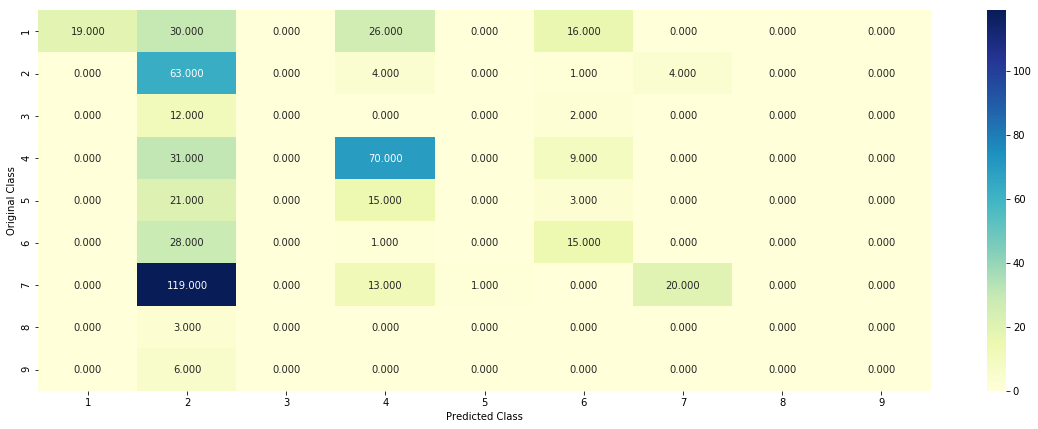

-------------------- Precision matrix (Columm Sum=1) --------------------


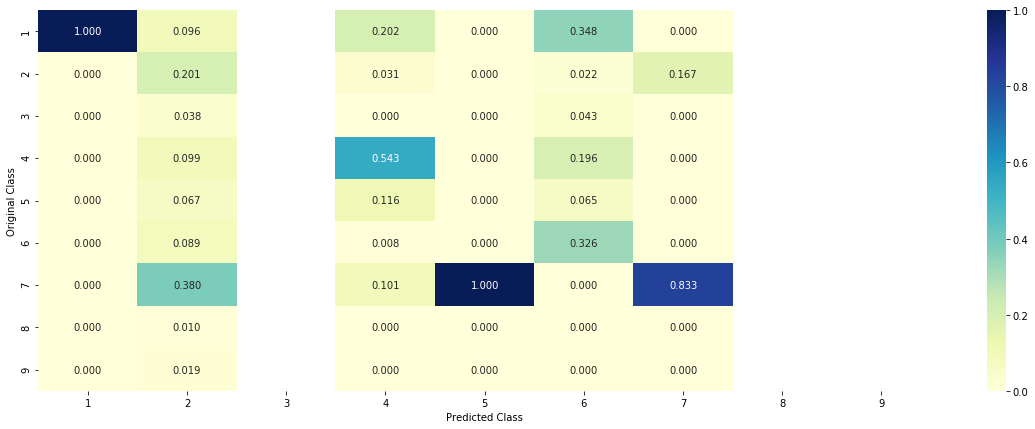

-------------------- Recall matrix (Row sum=1) --------------------


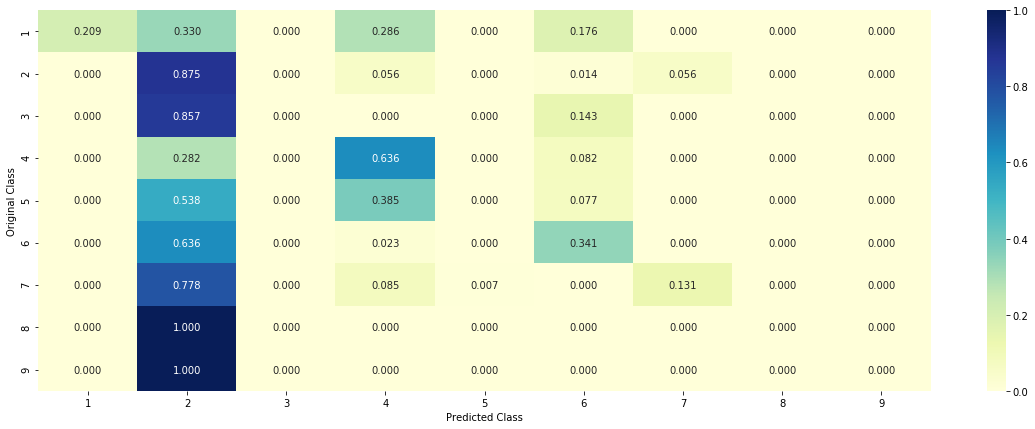

In [102]:
print('\x1b[1;03;55;55m')
print("Analysis of KNN")
bestk=buildModel(train_x_responseCoding,cv_x_responseCoding,test_x_responseCoding,'KNN')
clf = KNeighborsClassifier(n_neighbors=bestalpha)
sig_KNN=predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

In [105]:
df_KNN=testOnUnseenResponseCodedDataData(sig_KNN)
df_KNN[df_KNN['IsTrue']==False].shape

(430, 4)

<b>Total number of misclassified points for KNN with response coded features out of 665 is 430


Analysis of RF with response coding
+---------------+-----------------------+---------------------+
|     DEPTH     |        LOGLOSS        |     N_ESTIMATRS     |
+---------------+-----------------------+---------------------+
|       2       |     2.84985352452     |          10         |
|       3       |     2.48551455292     |          10         |
|       5       |     2.83336564717     |          10         |
|       10      |     2.31753808719     |          10         |
|       2       |     2.67103667566     |          50         |
|       3       |     2.63268890278     |          50         |
|       5       |     2.29696396427     |          50         |
|       10      |     2.62911901609     |          50         |
|       2       |      2.655831632      |         100         |
|       3       |      2.4727288993     |         100         |
|       5       |     2.14659668606     |         100         |
|       10      |     2.31341047902     |         100         |
|  

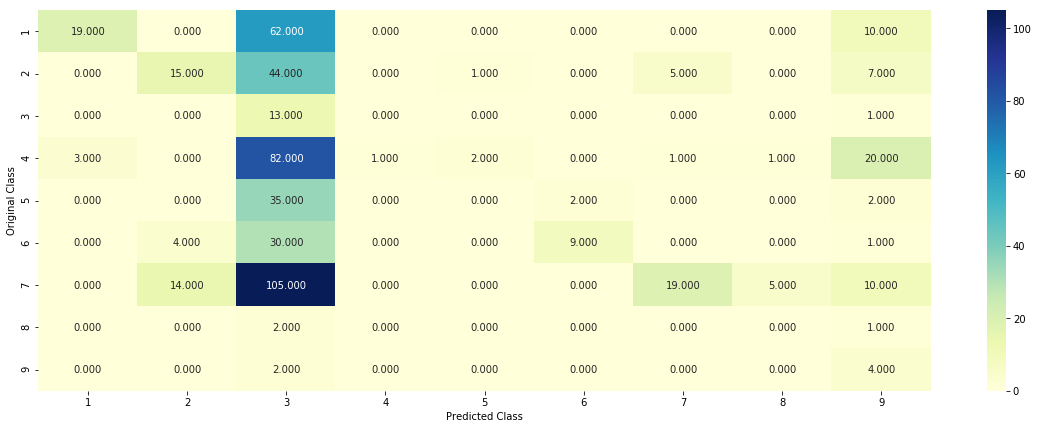

-------------------- Precision matrix (Columm Sum=1) --------------------


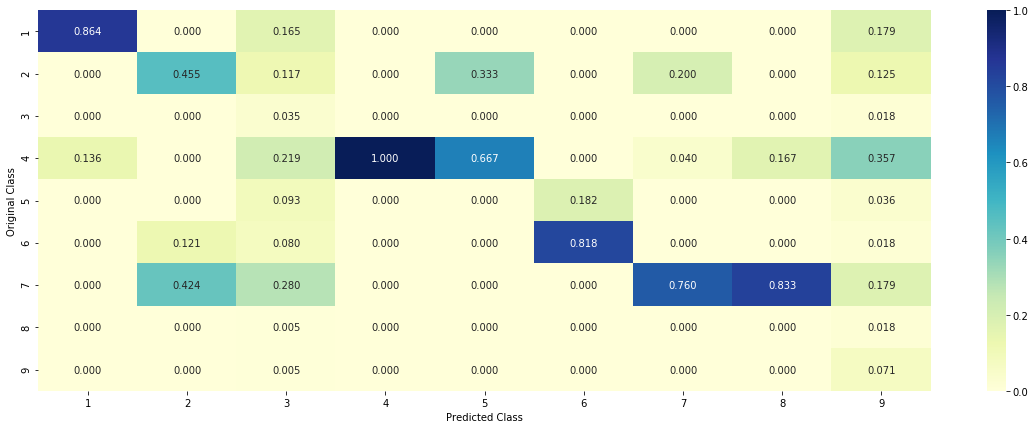

-------------------- Recall matrix (Row sum=1) --------------------


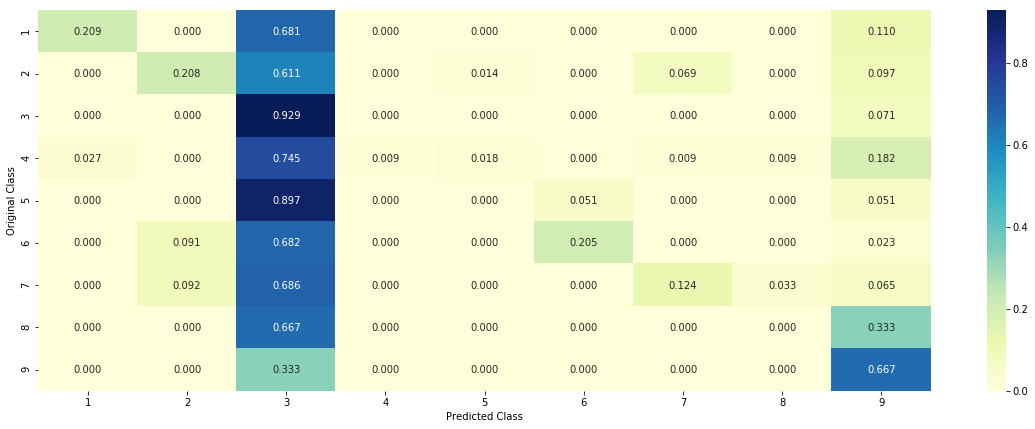

In [110]:
print('\x1b[1;03;55;55m')
print("Analysis of RF with response coding")
rf_response=buildRF(train_x_responseCoding,cv_x_responseCoding,test_x_responseCoding)

In [112]:
df_RF_Response=testOnUnseenResponseCodedDataData(rf_response)
df_RF_Response[df_RF_Response['IsTrue']==False].shape

(240, 4)


Analysis of SVM

+----------------+-----------------------+
|     ALPHA      |        LOGLOSS        |
+----------------+-----------------------+
|     1e-06      |      1.298802244      |
|     1e-05      |     1.29744775315     |
|     0.0001     |     1.28775526741     |
|     0.001      |     1.26309440206     |
|      0.01      |     1.12984994107     |
|      0.1       |      1.206264354      |
|      1.0       |     1.46425237509     |
|      10.0      |     1.60285543232     |
|     100.0      |     1.60277767484     |
+----------------+-----------------------+


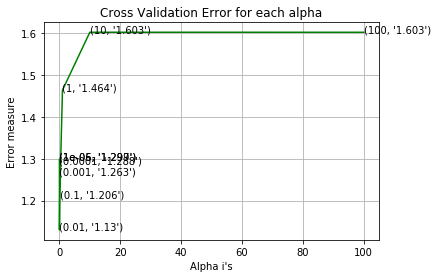


For values of best alpha =  0.01 The train log loss is: 0.495541340091
For values of best alpha =  0.01 The cross validation log loss is: 0.994144617915
For values of best alpha =  0.01 The test log loss is: 0.909068265101
Best alpha for model  SVM is  0.01
Log loss : 1.12984994107
Number of mis-classified points : 0.34398496240601506
-------------------- Confusion matrix --------------------


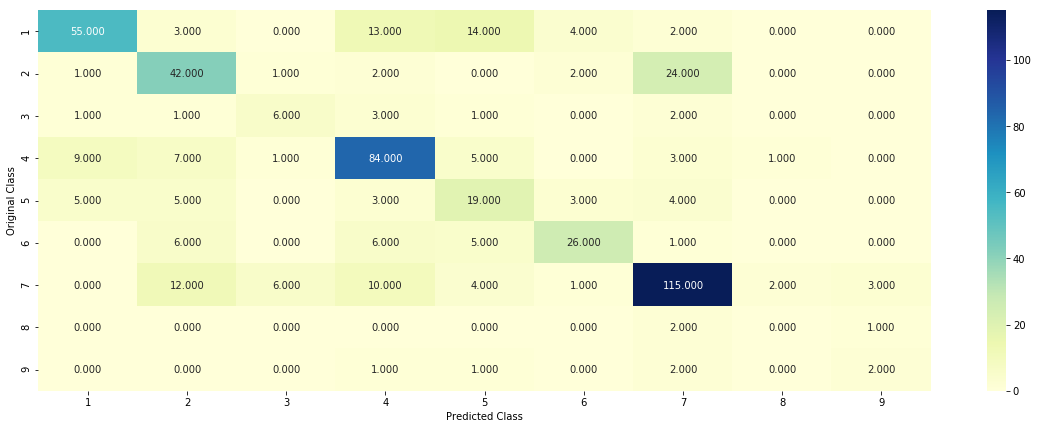

-------------------- Precision matrix (Columm Sum=1) --------------------


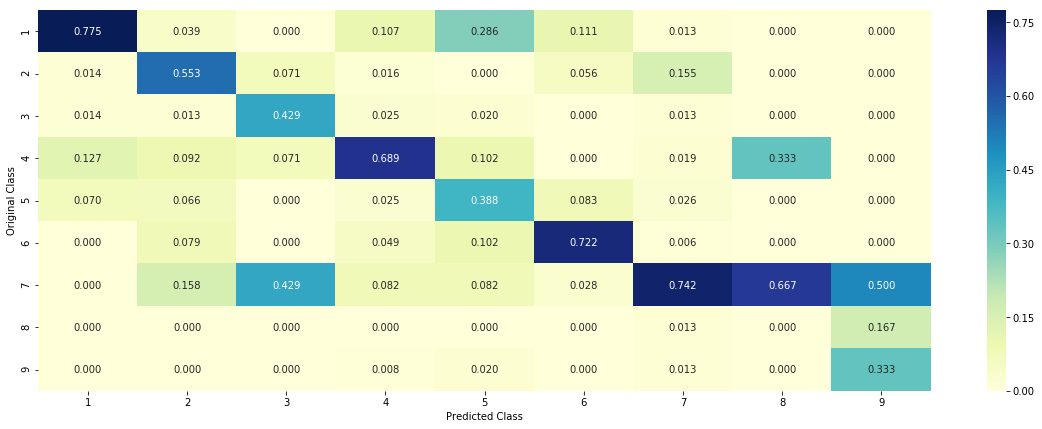

-------------------- Recall matrix (Row sum=1) --------------------


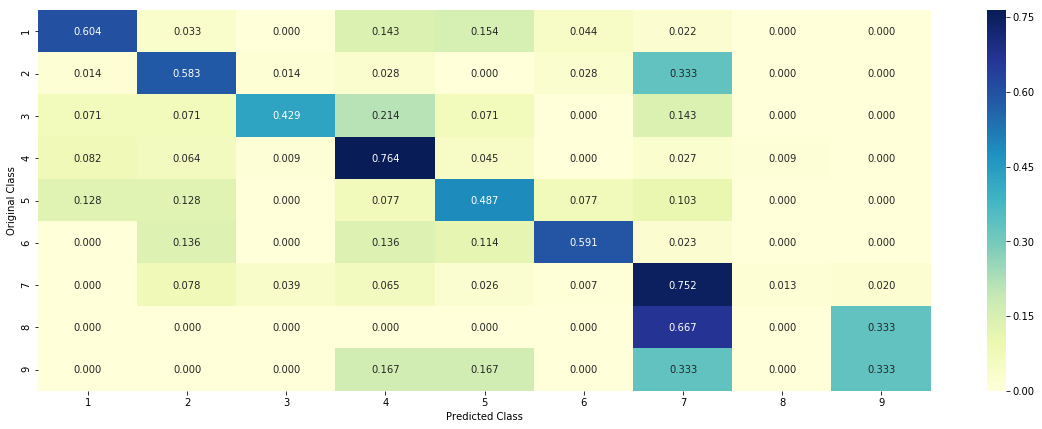

In [60]:
print('\x1b[1;03;55;55m')
print("Analysis of SVM")
bestalpha=buildModel(train_x_onehotCoding,cv_x_onehotCoding,test_x_onehotCoding,'SVM')
clf_SVM = SGDClassifier(class_weight='balanced', alpha=bestalpha , penalty='l2', loss='hinge', random_state=42)
sig_SVM=predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf_SVM)

In [62]:
df_SVM=testOnUnseenData(sig_SVM,clf_SVM)
df_SVM[df_SVM['IsTrue']==False].shape

(218, 4)

<b>Total number of misclassified points for SVM with class balancing out of 665 is 218

In [113]:

clf1 = SGDClassifier(alpha=0.01, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=0.01, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.000001)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 0.99
Support vector machines : Log Loss: 1.15
Naive Bayes : Log Loss: 1.30
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.175
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.008
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.419
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.063
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.134
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.280


Log loss (train) on the stacking classifier : 0.512427613397
Log loss (CV) on the stacking classifier : 1.06322315201
Log loss (test) on the stacking classifier : 1.01013314978
Number of missclassified point : 0.32030075187969925
-------------------- Confusion matrix --------------------


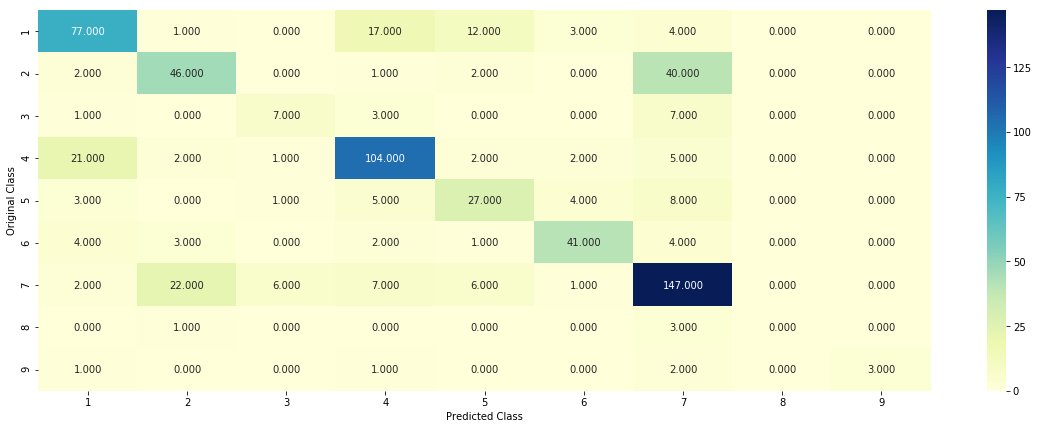

-------------------- Precision matrix (Columm Sum=1) --------------------


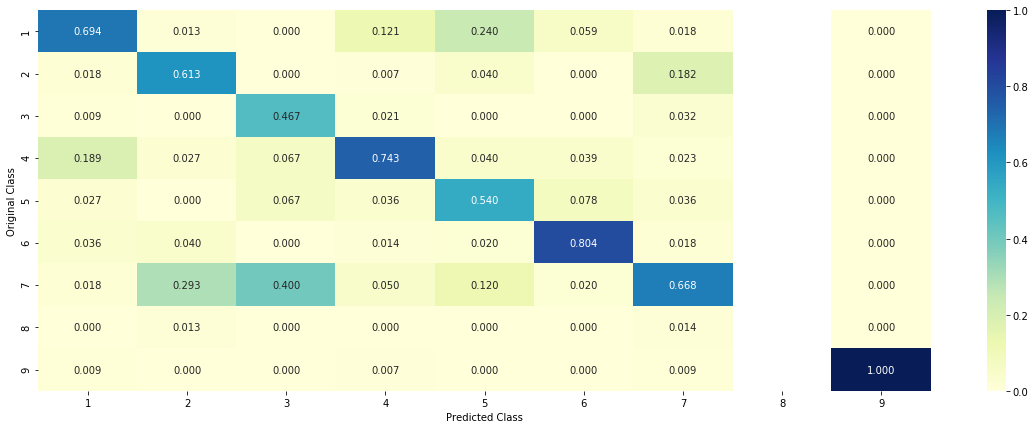

-------------------- Recall matrix (Row sum=1) --------------------


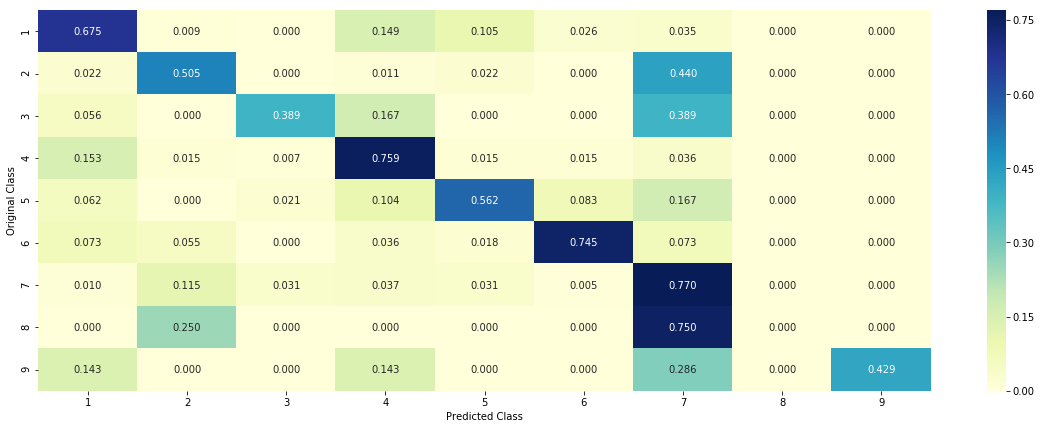

In [114]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))

In [377]:
df_Stack=testOnUnseenData(sclf,'None')
df_Stack[df_Stack['IsTrue']==False].shape

(213, 5)

Log loss (train) on the VotingClassifier : 0.613059142812
Log loss (CV) on the VotingClassifier : 1.07136717443
Log loss (test) on the VotingClassifier : 0.987903583401
Number of missclassified point : 0.3218045112781955
-------------------- Confusion matrix --------------------


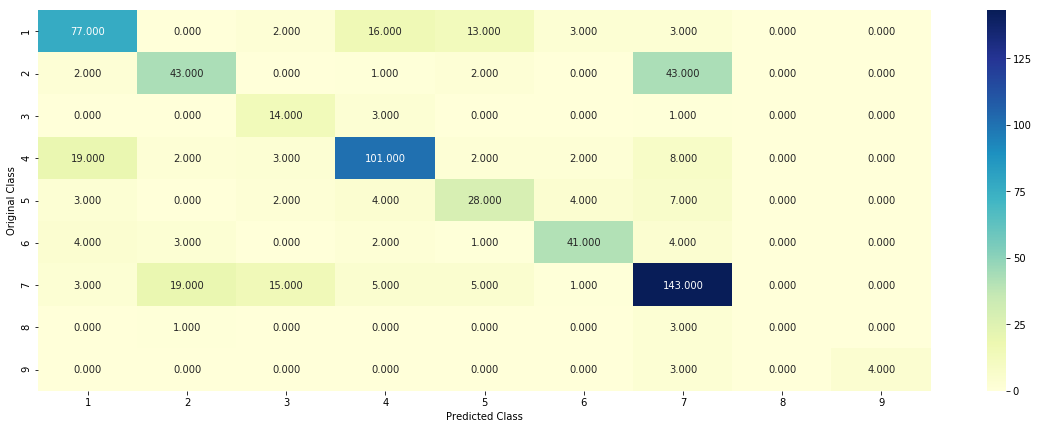

-------------------- Precision matrix (Columm Sum=1) --------------------


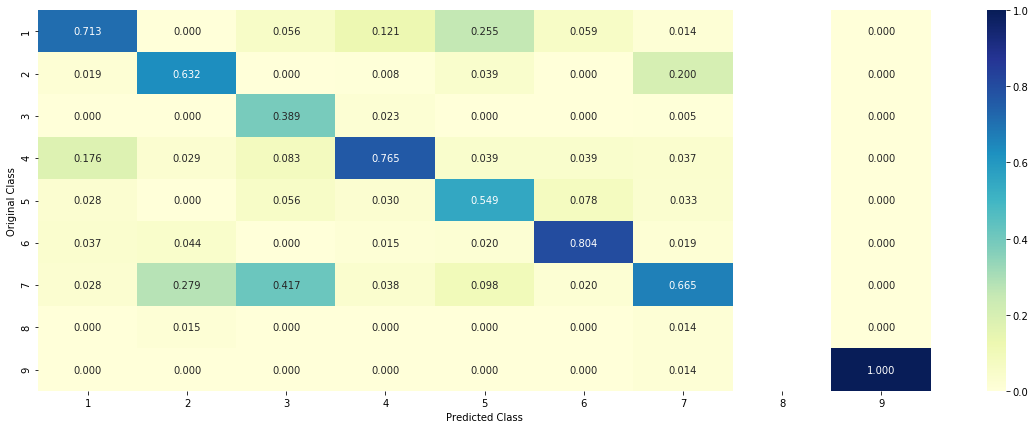

-------------------- Recall matrix (Row sum=1) --------------------


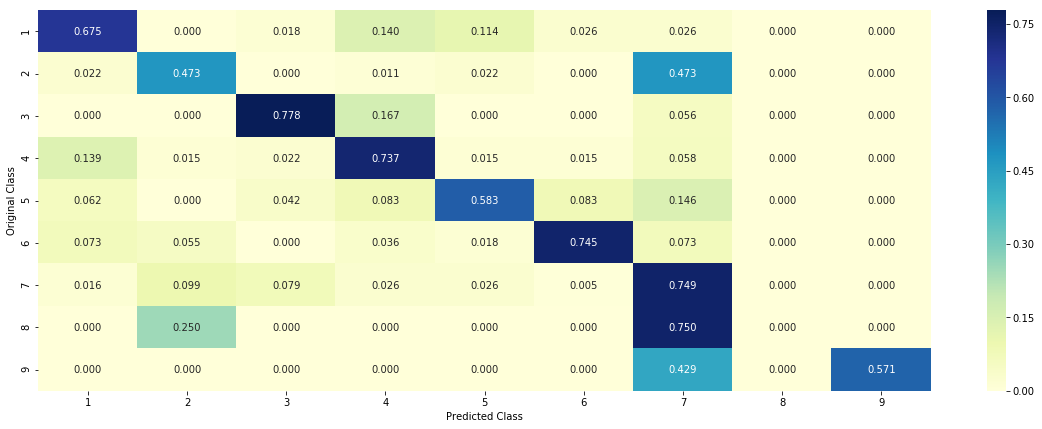

In [115]:
#Refer:http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_onehotCoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_onehotCoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_onehotCoding))

In [382]:
df_Vote=testOnUnseenData(vclf,'None')
df_Vote[df_Vote['IsTrue']==False].shape

(214, 5)

<h1> Summary

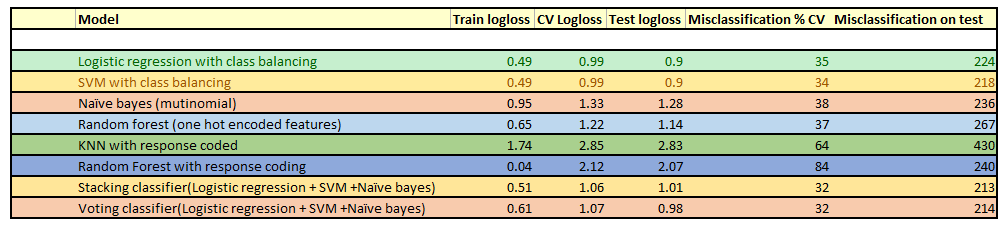

<b> 
<ul>
<li>The random forest with response coding clearly is a misfit for the data - its train loagloss and test cv logloss
differes a lot, it overfits to the training data
<li>KNN performs poor than the Random model (Logloss= ~2.44), KNN logloss for CV>2.44
<li>Voting classifier, Stacking classifier, SVM and Logistic regression with class balancing model performs well for this dataset

<h2> Test the unseen data with Voting,Stacking, SVM and Logistic regression with class balancing models

<h4>1. Logistic regression with class balancing

In [363]:
df_ClassBalanceLogLoss=testOnUnseenData(sig_clfLogRegBlance,clf_balance)
falseDf=pd.DataFrame(df_ClassBalanceLogLoss[df_ClassBalanceLogLoss['IsTrue']==False].head(5))
trueDf=pd.DataFrame(df_ClassBalanceLogLoss[df_ClassBalanceLogLoss['IsTrue']==True].head(5))
pd.concat([trueDf,falseDf])

,Actual,Important features,IsTrue,Predicted,Probability
0,2,"[ccnd1, shp, hotspots, harbored, pest, patients, median]",True,2,"[[0.1468, 0.5024, 0.0047, 0.1198, 0.0124, 0.016, 0.1843, 0.0038, 0.0099]]"
1,4,"[nonsense, caax, unstable, orthologs, c124s, hamartoma, wpd, pten, defective, ubiquitination, g129r, cowden, deleted, microscopy, ubiquitin, h93r, s170r, phosphoinositide, truncated, suppressor]",True,4,"[[0.0059, 0.0016, 0.1926, 0.7867, 0.0047, 0.0046, 0.0003, 0.0015, 0.0021]]"
2,7,"[tyrosine, conferred, doses, constitutive, preclinical, allosteric, erk1, constitutively, refractory, kinase, gef, erk, ligand, mek1, untreated, mek, phosphorylation, neratinib, biopsies, erlotinib]",True,7,"[[0.0202, 0.3022, 0.0043, 0.0075, 0.0109, 0.0146, 0.6345, 0.0028, 0.003]]"
3,2,"[vegfa, hif2, invasion, hotspots, adenoma, rearrangements, patients, belonging, spindle]",True,2,"[[0.0172, 0.9541, 0.0039, 0.0078, 0.0054, 0.0062, 0.0011, 0.0016, 0.0027]]"
4,1,"[otherwise, aggregation, frameshift, modifications, linker, phosphorylates, modification, repeats]",True,1,"[[0.9741, 0.0031, 0.0042, 0.0051, 0.0044, 0.0048, 0.0003, 0.0018, 0.0022]]"
6,4,"[p53s, r273h, p21waf1, saos, folded, tetramer, p53, aggregation, r249s, frameshift, damage, tp53, mdm2, bax, p21, groove, folding, destabilizing, deficient]",False,1,"[[0.4587, 0.0472, 0.0055, 0.3487, 0.0165, 0.0138, 0.1016, 0.0023, 0.0059]]"
10,5,"[potency, 3t3, transforming, erk1, mitogen, kinase, erk, mek1, mek, phosphorylation, lobe, noonan, signaling, mapk, activated, oncogenic, raf1, kinases, acquired, transduction]",False,7,"[[0.0692, 0.1483, 0.02, 0.0621, 0.0529, 0.0502, 0.5882, 0.004, 0.005]]"
12,7,"[gender, patients, median, coil]",False,2,"[[0.137, 0.423, 0.015, 0.2069, 0.0344, 0.1039, 0.062, 0.0089, 0.0088]]"
14,7,"[y572c, v592g, s451f, r834q, mln518, presumptive]",False,3,"[[0.025, 0.0312, 0.6348, 0.0176, 0.0142, 0.0151, 0.2553, 0.0023, 0.0044]]"
15,4,[],False,3,"[[0.3549, 0.0126, 0.5146, 0.0756, 0.0159, 0.0181, 0.0019, 0.0024, 0.0039]]"


<h4>2. SVM with class balancing 

In [367]:
df_SVM=testOnUnseenData(sig_SVM,clf_SVM)
falseDf_SVM=pd.DataFrame(df_SVM[df_SVM['IsTrue']==False].head(5))
trueDf_SVM=pd.DataFrame(df_SVM[df_SVM['IsTrue']==True].head(5))
pd.concat([trueDf,falseDf])

,Actual,Important features,IsTrue,Predicted,Probability
0,2,"[ccnd1, shp, hotspots, harbored, pest, patients, median]",True,2,"[[0.1468, 0.5024, 0.0047, 0.1198, 0.0124, 0.016, 0.1843, 0.0038, 0.0099]]"
1,4,"[nonsense, caax, unstable, orthologs, c124s, hamartoma, wpd, pten, defective, ubiquitination, g129r, cowden, deleted, microscopy, ubiquitin, h93r, s170r, phosphoinositide, truncated, suppressor]",True,4,"[[0.0059, 0.0016, 0.1926, 0.7867, 0.0047, 0.0046, 0.0003, 0.0015, 0.0021]]"
2,7,"[tyrosine, conferred, doses, constitutive, preclinical, allosteric, erk1, constitutively, refractory, kinase, gef, erk, ligand, mek1, untreated, mek, phosphorylation, neratinib, biopsies, erlotinib]",True,7,"[[0.0202, 0.3022, 0.0043, 0.0075, 0.0109, 0.0146, 0.6345, 0.0028, 0.003]]"
3,2,"[vegfa, hif2, invasion, hotspots, adenoma, rearrangements, patients, belonging, spindle]",True,2,"[[0.0172, 0.9541, 0.0039, 0.0078, 0.0054, 0.0062, 0.0011, 0.0016, 0.0027]]"
4,1,"[otherwise, aggregation, frameshift, modifications, linker, phosphorylates, modification, repeats]",True,1,"[[0.9741, 0.0031, 0.0042, 0.0051, 0.0044, 0.0048, 0.0003, 0.0018, 0.0022]]"
6,4,"[p53s, r273h, p21waf1, saos, folded, tetramer, p53, aggregation, r249s, frameshift, damage, tp53, mdm2, bax, p21, groove, folding, destabilizing, deficient]",False,1,"[[0.4587, 0.0472, 0.0055, 0.3487, 0.0165, 0.0138, 0.1016, 0.0023, 0.0059]]"
10,5,"[potency, 3t3, transforming, erk1, mitogen, kinase, erk, mek1, mek, phosphorylation, lobe, noonan, signaling, mapk, activated, oncogenic, raf1, kinases, acquired, transduction]",False,7,"[[0.0692, 0.1483, 0.02, 0.0621, 0.0529, 0.0502, 0.5882, 0.004, 0.005]]"
12,7,"[gender, patients, median, coil]",False,2,"[[0.137, 0.423, 0.015, 0.2069, 0.0344, 0.1039, 0.062, 0.0089, 0.0088]]"
14,7,"[y572c, v592g, s451f, r834q, mln518, presumptive]",False,3,"[[0.025, 0.0312, 0.6348, 0.0176, 0.0142, 0.0151, 0.2553, 0.0023, 0.0044]]"
15,4,[],False,3,"[[0.3549, 0.0126, 0.5146, 0.0756, 0.0159, 0.0181, 0.0019, 0.0024, 0.0039]]"


<h4>3. Stacking classifier (Log reg+ SVM + Naive bayes)

In [378]:

falseDf_Stack=pd.DataFrame(df_Stack[df_Stack['IsTrue']==False].head(5))
trueDf_Stack=pd.DataFrame(df_Stack[df_Stack['IsTrue']==True].head(5))
pd.concat([trueDf_Stack,falseDf_Stack])

,Actual,Important features,IsTrue,Predicted,Probability
0,2,,True,2,"[[0.0526, 0.6815, 0.0264, 0.0533, 0.0344, 0.0328, 0.0808, 0.0177, 0.0204]]"
1,4,,True,4,"[[0.0322, 0.02, 0.0394, 0.8088, 0.0289, 0.0238, 0.0168, 0.0137, 0.0164]]"
2,7,,True,7,"[[0.0187, 0.0889, 0.0184, 0.0207, 0.0209, 0.0208, 0.7848, 0.0124, 0.0144]]"
3,2,,True,2,"[[0.0262, 0.8117, 0.0246, 0.0232, 0.0333, 0.0319, 0.0129, 0.0172, 0.019]]"
4,1,,True,1,"[[0.8183, 0.0231, 0.0208, 0.031, 0.0317, 0.0259, 0.0181, 0.0142, 0.0169]]"
6,4,,False,1,"[[0.498, 0.0338, 0.0279, 0.2942, 0.0369, 0.0316, 0.0408, 0.0169, 0.0199]]"
10,5,,False,7,"[[0.0315, 0.0811, 0.0233, 0.0356, 0.0311, 0.0291, 0.7368, 0.0146, 0.017]]"
12,7,,False,2,"[[0.0874, 0.5725, 0.0345, 0.1054, 0.0496, 0.0603, 0.0439, 0.0215, 0.0249]]"
15,4,,False,1,"[[0.4453, 0.057, 0.2, 0.0741, 0.069, 0.054, 0.0443, 0.0255, 0.0308]]"
25,7,,False,2,"[[0.0322, 0.7234, 0.0242, 0.0268, 0.0309, 0.0297, 0.0983, 0.0162, 0.0183]]"


<h4>4. Voting classifier (Log reg+ SVM + Naive bayes)

In [381]:

falseDf_Vote=pd.DataFrame(df_Vote[df_Vote['IsTrue']==False].head(5))
trueDf_Vote=pd.DataFrame(df_Vote[df_Vote['IsTrue']==True].head(5))
pd.concat([trueDf_Vote,falseDf_Vote])

,Actual,Important features,IsTrue,Predicted,Probability
0,2,,True,2,"[[0.1118, 0.5035, 0.0082, 0.1139, 0.0236, 0.0289, 0.1971, 0.0042, 0.009]]"
1,4,,True,4,"[[0.0586, 0.0411, 0.0975, 0.7234, 0.019, 0.019, 0.0328, 0.0033, 0.0055]]"
2,7,,True,7,"[[0.0645, 0.1667, 0.0091, 0.0617, 0.0252, 0.0279, 0.6357, 0.0041, 0.0051]]"
3,2,,True,2,"[[0.041, 0.8371, 0.0085, 0.0385, 0.0206, 0.0228, 0.0247, 0.0023, 0.0046]]"
4,1,,True,1,"[[0.8091, 0.0533, 0.0087, 0.0427, 0.0228, 0.0225, 0.0331, 0.0032, 0.0047]]"
6,4,,False,1,"[[0.4459, 0.0745, 0.0105, 0.2971, 0.0322, 0.0309, 0.0978, 0.0038, 0.0074]]"
10,5,,False,7,"[[0.092, 0.1405, 0.0197, 0.0947, 0.0514, 0.0468, 0.5448, 0.0044, 0.0058]]"
12,7,,False,2,"[[0.1376, 0.4232, 0.0201, 0.1609, 0.0419, 0.0856, 0.1139, 0.007, 0.0099]]"
14,7,,False,3,"[[0.0948, 0.0606, 0.4219, 0.0669, 0.0269, 0.0297, 0.2874, 0.0044, 0.0075]]"
15,4,,False,3,"[[0.3454, 0.0642, 0.416, 0.0703, 0.03, 0.0281, 0.0361, 0.0034, 0.0063]]"


<li><h4> If important features are required then Logistic regression or SVM should be used.
<li><h4> If important features are not required then - we can go with Voting or Stacking classifier with SVM Logistic regression and Naive bayes